Bag root: 
Found 25 bags
✔ 2tb4_0SINR_besteffort_maxspeed_0.db3
✔ 2tb4_35SINR_besteffort_maxspeed_0.db3
✔ 2tb4_35SINR_besteffort_maxspeed_2_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.15speed_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.3speed_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.3speed_2_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.3speed_3_0.db3
✔ 2tb4_LIVE_SINR_besteffort_maxspeed_0.db3
✔ 2tb4_0SINR_besteffort_maxspeed_0.db3
✔ rosbag2_2025_10_27-20_37_41_0.db3
✔ 2tb4_35SINR_besteffort_maxspeed_2_0.db3
✔ 2tb4_LIVE_SINR_besteffort_maxspeed_0.db3
✔ rosbag2_2025_10_27-21_04_45_0.db3
✔ 2tb4_0SINR_reliable_maxspeed_0.db3
✔ 2tb4_35SINR_reliable_maxspeed_0.db3
✔ 2tb4_LIVE_SINR_reliable_0.15speed_0.db3
✔ 2tb4_LIVE_SINR_reliable_0.3speed_0.db3
✔ 2tb4_LIVE_SINR_reliable_maxspeed_0.db3
✔ 2tb4_LIVE_SINR_reliable_maxspeed_2_0.db3
✔ Hallway_35_SINR_reliable_maxspeed_0.db3
✔ Hallway_LIVE_SINR_reliable_maxspeed_0.db3
✔ 2tb4_LIVE_SINR_reliable_maxspeed_2_0.db3
✖ pair_2tb4_0SINR_besteffort_maxspeed_0.db3_vs_2tb4_0SINR_reliable_

,bag,qos,sinr,speed,Qc,Eavg,R,p_cmd_succ,p_cmd_drop,cmd_rate_hz,lat_med,jitter_std,Qenergy
3,2tb4_LIVE_SINR_besteffort_0.15speed_0.db3,best_effort,NaN,0.15,2.281618e-03,33.999229,0.800676,0.998103,0.000100,20.000162,0.033057,0.002943,0.070205
4,2tb4_LIVE_SINR_besteffort_0.3speed_0.db3,best_effort,NaN,0.3,1.362466e-04,34.348426,0.897060,1.000000,0.000000,20.000305,0.022005,0.000052,0.001821
5,2tb4_LIVE_SINR_besteffort_0.3speed_2_0.db3,best_effort,NaN,0.3,1.654629e-03,34.336583,0.793874,0.999865,0.000135,20.000305,0.035296,0.002731,0.004140
6,2tb4_LIVE_SINR_besteffort_0.3speed_3_0.db3,best_effort,NaN,0.3,2.358646e-03,33.135775,0.911042,1.000000,0.000000,20.000496,0.018706,0.000032,0.239298
0,2tb4_0SINR_besteffort_maxspeed_0.db3,best_effort,0.0,max,3.227098e-03,33.765330,0.847345,1.000000,0.000000,20.000496,0.033178,0.000033,0.116011
8,2tb4_0SINR_besteffort_maxspeed_0.db3,best_effort,0.0,max,2.264515e-03,33.624171,0.947906,1.000000,0.000000,20.000210,0.010586,0.000032,0.143654
12,rosbag2_2025_10_27-21_04_45_0.db3,best_effort,0.0,max,1.911909e-03,14.857602,0.816632,0.500000,0.000000,10.000200,0.040391,0.000030,1.000000
1,2tb4_35SINR_besteffort_maxspeed_0.db3,best_effort,35.0,max,6.816008e-08,33.247264,0.879541,1.000000,0.000000,20.000210,0.025577,0.000030,0.217465
2,2tb4_35SINR_besteffort_maxspeed_2_0.db3,best_effort,35.0,max,2.787393e-03,32.951382,0.851365,1.000000,0.000000,20.000210,0.032267,0.000038,0.275408
10,2tb4_35SINR_besteffort_maxspeed_2_0.db3,best_effort,35.0,max,2.103859e-03,32.804646,0.904600,1.000000,0.000000,20.000186,0.020244,0.000034,0.304144


,speed,sinr,Qc_BE,Qc_REL,Qe_BE,Qe_REL,R_BE,R_REL,n_BE,n_REL
0,0.15,NaN,0.002282,0.001978,0.070205,0.238405,0.800676,0.874843,1,1
1,0.3,NaN,0.001383,0.001108,0.081753,0.239551,0.867325,0.875344,3,1
2,max,0.0,0.002468,0.003165,0.419888,0.106839,0.870628,0.936219,3,1
3,max,35.0,0.001223,0.003238,0.284265,0.231902,0.866898,0.944580,4,1
4,max,NaN,0.002496,0.001379,0.178786,0.312047,0.866386,0.855822,2,3


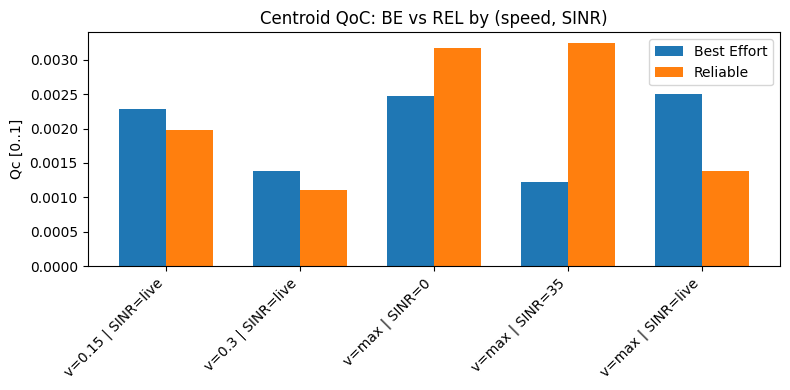

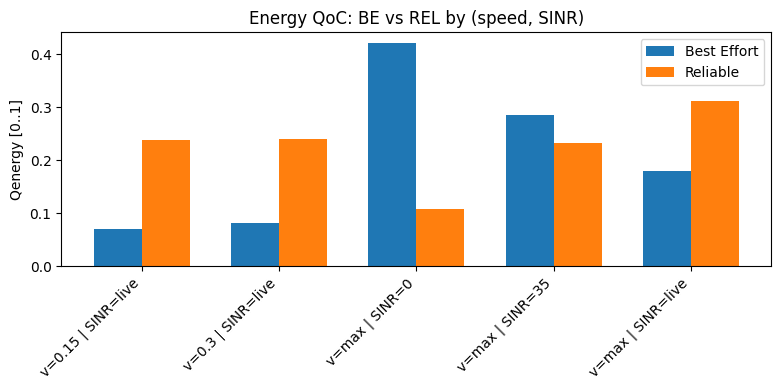

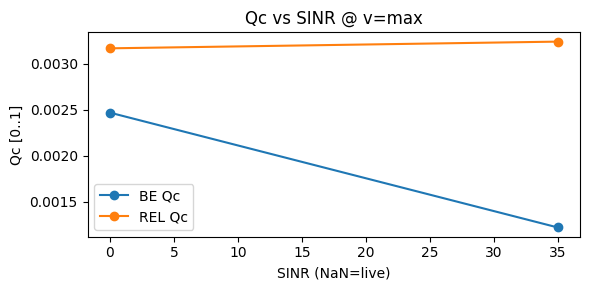

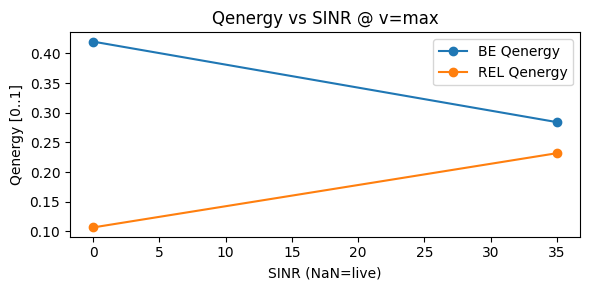

In [18]:
# %% [markdown]
# # Multi-Run QoC Analysis (v6) — Centroid QoC, Energy QoC, Reliability, and **BE vs REL** Comparisons
# This notebook computes and plots:
# - **Centroid QoC** (normalized AUC of centroid disagreement).
# - **Energy-aware QoC** (path length + smoothness; robust batch normalization).
# - **Reliability metrics** from `/cmd_vel` and cmd→odom latency.
# - **Best Effort vs Reliable** comparisons of **Qc** and **Qenergy** (grouped by *(speed, SINR)*), plus pairwise overlays.

# %% [markdown]
# ## Mathematical Model, QoC & Reliability
# Let the centroid be \( \mathbf{c}(t) = \frac{1}{N}\sum_i \mathbf{x}_i(t) \) and the average disagreement
# \( e(t)=\frac{1}{N}\sum_i \lVert \mathbf{x}_i(t)-\mathbf{c}(t)\rVert^2 \).
# We compute on a uniform grid \(t_k=k\Delta t\):
# \[
# J^{\mathrm C}=\int_0^T e(t)\,dt\approx\sum_k e(t_k)\Delta t,\quad
# J^{\mathrm C}_{\text{norm}}=\frac{J^{\mathrm C}}{e_0},\quad
# Q^{\mathrm C}=\frac{1}{1+J^{\mathrm C}_{\text{norm}}}.
# \]
# Energy QoC (per robot \(i\)): \(E_i=L_i+\lambda\sum_k a_i^2\Delta t\). Batch-normalize:
# \(Q^{\mathrm E}=\mathrm{clip}((E_{95}-E_{\text{avg}})/(E_{95}-E_{05}),0,1)\).
#
# Reliability from `/cmd_vel`: median period \(T_{\text{cmd}}\), on-time \(p_{\text{succ}}\) (≤1.5\(T_{\text{cmd}}\)), drop \(p_{\text{drop}}\) (>3\(T_{\text{cmd}}\)), jitter, and cmd→odom latency.
# Combined score \(R=(r_1 r_2 r_3 r_4)^{1/2}\) with \(r_1=p_{\text{succ}}, r_2=1-p_{\text{drop}}, r_3=e^{-\text{lat}_{\text{med}}/(2T_{\text{cmd}})}, r_4=e^{-\sigma_{\text{jitter}}/(0.5T_{\text{cmd}})}\).

# %%
# --- Config ---
BAG_ROOT = ""          # <-- set to the parent folder that holds your .db3 bags
ROBOT_NS = ["tb4_1", "tb4_2"]   # the two turtlebots
DT_RESAMPLE = 0.05              # seconds
OUTDIR = "qoc_v6_out"

import os, re, glob, importlib, types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Safety: ensure pd really is pandas (guards against 'pd = [...]' mistakes in earlier cells)
if not isinstance(pd, types.ModuleType) or not hasattr(pd, "DataFrame"):
    import pandas as _pandas
    pd = importlib.reload(_pandas)

os.makedirs(OUTDIR, exist_ok=True)
print("Bag root:", BAG_ROOT)

# %%
# Find bags & parse metadata from filenames/parent dirs
def find_bags(root):
    return sorted(glob.glob(os.path.join(root, "**", "*.db3"), recursive=True))

def parse_meta_from_name(path):
    name   = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    text   = f"{parent}__{name}".replace(" ", "_")
    qos = "best_effort" if "besteffort" in text else ("reliable" if "reliable" in text else "unknown")
    sinr = None
    m = re.search(r"(\d+)\s*?sinr", text)
    if m: sinr = float(m.group(1))
    if "live_sinr" in text: sinr = np.nan
    speed = None
    m2 = re.search(r"(\d+(\.\d+)?)\s*speed", text)
    if m2: speed = float(m2.group(1))
    if "maxspeed" in text: speed = "max"
    return {"qos": qos, "sinr": sinr, "speed": speed, "label": os.path.basename(path)}

bags    = find_bags(BAG_ROOT)
meta_df = pd.DataFrame([dict(path=b, **parse_meta_from_name(b)) for b in bags])
print(f"Found {len(bags)} bags")
meta_df.head()

# %%
# rosbags helpers
from rosbags.highlevel import AnyReader
from rosbags.typesys   import get_typestore, Stores

def make_typestore():
    for c in (Stores.ROS2_HUMBLE, Stores.ROS2_IRON, Stores.ROS2_JAZZY, Stores.ROS2_FOXY):
        try:
            return get_typestore(c)
        except Exception:
            pass
    return get_typestore(Stores.ROS2_HUMBLE)

def list_topics(reader):
    return sorted({c.topic for c in reader.connections})

def extract_odom(reader, topic):
    conns = [c for c in reader.connections if c.topic == topic]
    rows  = []
    for conn in conns:
        for _conn, t_ns, raw in reader.messages(connections=[conn]):
            msg = reader.deserialize(raw, conn.msgtype)
            t   = t_ns * 1e-9
            try:
                hs = msg.header.stamp.sec + 1e-9*msg.header.stamp.nanosec
                if hs > 0 and abs(hs - t) < 1.0 and (not rows or hs >= rows[-1][0]):
                    t = hs
            except Exception:
                pass
            x  = getattr(msg.pose.pose.position,  "x", float("nan"))
            y  = getattr(msg.pose.pose.position,  "y", float("nan"))
            z  = getattr(msg.pose.pose.position,  "z", float("nan"))
            vx = getattr(msg.twist.twist.linear, "x", float("nan"))
            vy = getattr(msg.twist.twist.linear, "y", float("nan"))
            vz = getattr(msg.twist.twist.linear, "z", float("nan"))
            rows.append((t,x,y,z,vx,vy,vz))
    if not rows: return None
    df = pd.DataFrame(rows, columns=["t","x","y","z","vx","vy","vz"]).sort_values("t").drop_duplicates("t")
    return df

def extract_cmdvel(reader, topic):
    conns = [c for c in reader.connections if c.topic == topic]
    rows  = []
    for conn in conns:
        for _conn, t_ns, raw in reader.messages(connections=[conn]):
            msg = reader.deserialize(raw, conn.msgtype)
            t   = t_ns * 1e-9
            try:
                hs = msg.header.stamp.sec + 1e-9*msg.header.stamp.nanosec
                if hs > 0 and abs(hs - t) < 1.0 and (not rows or hs >= rows[-1][0]):
                    t = hs
            except Exception:
                pass
            vx = getattr(msg.linear,  "x", float("nan"))
            wz = getattr(msg.angular, "z", float("nan"))
            rows.append((t, vx, wz))
    if not rows: return None
    df = pd.DataFrame(rows, columns=["t","vx","wz"]).sort_values("t").drop_duplicates("t")
    return df

# %%
# Metrics
def resample_to_grid(trajs, dt):
    tmin = min(df["t"].min() for df in trajs.values())
    tmax = max(df["t"].max() for df in trajs.values())
    t = np.arange(tmin, tmax + 0.5*dt, dt)
    out = {}
    for name, df in trajs.items():
        tt = df["t"].to_numpy()
        def interp_or_hold(values):
            arr = np.asarray(values); fin = np.isfinite(arr)
            if np.sum(fin) >= 2 and len(tt) >= 2:
                return np.interp(t, tt, arr, left=arr[fin][0], right=arr[fin][-1])
            val = arr[fin][0] if np.any(fin) else 0.0
            return np.full_like(t, float(val))
        out[name] = pd.DataFrame({
            "t": t,
            "x": interp_or_hold(df["x"]), "y": interp_or_hold(df["y"]), "z": interp_or_hold(df["z"]),
            "vx": interp_or_hold(df["vx"]), "vy": interp_or_hold(df["vy"]), "vz": interp_or_hold(df["vz"]),
        })
    return t, out

def centroid_qoc_runlevel(resampled):
    names = list(resampled.keys())
    T = resampled[names[0]]["t"].to_numpy()
    X = np.vstack([resampled[n]["x"].to_numpy() for n in names])
    Y = np.vstack([resampled[n]["y"].to_numpy() for n in names])
    XC, YC = X.mean(axis=0), Y.mean(axis=0)
    dt = np.diff(T, prepend=T[0])
    n2_all = np.vstack([(X[i]-XC)**2 + (Y[i]-YC)**2 for i in range(len(names))])
    n2_avg = n2_all.mean(axis=0)
    J = float(np.sum(n2_avg * dt))
    e0 = float(np.mean(n2_all[:,0]))
    if not np.isfinite(e0) or e0 <= 1e-12:
        e0 = float(np.nanmean(n2_avg[:max(5, n2_avg.size//10)])) or 1.0
    Jnorm     = J / e0
    Q         = 1.0 / (1.0 + Jnorm)
    Jcum_norm = np.cumsum(n2_avg * dt) / e0
    return {"T":T, "XC":XC, "YC":YC, "n2_avg":n2_avg, "Jnorm":Jnorm, "Q":Q, "Jcum_norm":Jcum_norm}

def energy_qoc_runlevel(resampled, smooth_lambda=0.2):
    names = list(resampled.keys())
    T  = resampled[names[0]]["t"].to_numpy()
    dt = np.diff(T, prepend=T[0])
    Ls, Es, Ds = [], [], []
    for name in names:
        x  = resampled[name]["x"].to_numpy(); y = resampled[name]["y"].to_numpy()
        vx = resampled[name]["vx"].to_numpy(); vy= resampled[name]["vy"].to_numpy()
        v  = np.hypot(vx, vy)
        L  = float(np.sum(np.hypot(np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0]))))
        a  = np.diff(v, prepend=v[0]) / np.where(dt>0, dt, 1.0)
        smooth_pen = float(np.sum((a*a) * dt))
        E  = L + smooth_pen * smooth_lambda
        D  = float(np.hypot(x[-1]-x[0], y[-1]-y[0]))
        Ls.append(L); Es.append(E); Ds.append(D)
    Lavg, Eavg, Davg = np.mean(Ls), np.mean(Es), np.mean(Ds)
    eff = Davg / Lavg if Lavg > 1e-9 else 1.0
    return {"Eavg":Eavg, "Lavg":Lavg, "Davg":Davg, "eff":eff}

def reliability_metrics(cmd_df, odom_df):
    if cmd_df is None or len(cmd_df) < 2:
        return {"rate_hz":0.0, "Tcmd":np.nan, "p_succ":0.0, "p_drop":np.nan,
                "jitter_std":np.nan, "lat_med":np.nan}
    t_cmd = cmd_df["t"].to_numpy()
    d = np.diff(t_cmd)
    Tcmd = float(np.median(d)) if d.size else np.nan
    rate = 1.0/Tcmd if Tcmd and Tcmd>0 else 0.0
    if np.isnan(Tcmd) or Tcmd<=0:
        return {"rate_hz":0.0, "Tcmd":np.nan, "p_succ":0.0, "p_drop":np.nan,
                "jitter_std":np.nan, "lat_med":np.nan}
    th1, th2 = 1.5*Tcmd, 3.0*Tcmd
    p_succ   = float(np.mean(d <= th1)) if d.size else np.nan
    p_drop   = float(np.mean(d >  th2)) if d.size else np.nan
    jitter   = float(np.std(d - Tcmd)) if d.size else np.nan

    lat_med = np.nan
    if odom_df is not None and len(odom_df) > 1:
        t_odom = odom_df["t"].to_numpy()
        idx = np.searchsorted(t_odom, t_cmd, side="left")
        valid = idx < t_odom.size
        if np.any(valid):
            lat = t_odom[idx[valid]] - t_cmd[valid]
            lat = lat[(lat >= 0) & (lat < 5.0)]
            if lat.size:
                lat_med = float(np.median(lat))
    return {"rate_hz":rate, "Tcmd":Tcmd, "p_succ":p_succ, "p_drop":p_drop, "jitter_std":jitter, "lat_med":lat_med}

def combined_reliability(r):
    if r is None: return np.nan
    T = r.get("Tcmd", np.nan)
    r1 = r.get("p_succ", np.nan)
    r2 = 1.0 - r.get("p_drop", np.nan) if not np.isnan(r.get("p_drop", np.nan)) else np.nan
    r3 = np.exp(-r.get("lat_med", np.nan) / (2*T)) if (T and T>0 and not np.isnan(r.get("lat_med", np.nan))) else np.nan
    r4 = np.exp(-r.get("jitter_std", np.nan) / (0.5*T)) if (T and T>0 and not np.isnan(r.get("jitter_std", np.nan))) else np.nan
    comps = [r1, r2, r3, r4]
    if any(np.isnan(c) for c in comps): 
        return np.nan
    return float((np.prod(comps))**0.5)

# %%
# Per-bag processing
def process_bag(db3_path, robot_ns=ROBOT_NS, dt=DT_RESAMPLE, outdir=OUTDIR):
    typestore = make_typestore()
    bag_input = Path(db3_path)
    bag_dir   = bag_input.parent if bag_input.is_file() else bag_input

    with AnyReader([bag_dir], default_typestore=typestore) as reader:
        available   = list_topics(reader)
        odom_topics = [f"/{ns}/odom" for ns in robot_ns if f"/{ns}/odom" in available]
        if len(odom_topics) < 2:
            return {"error": f"Need 2 odom topics; found {odom_topics} among {available[:10]}"}

        trajs = {tp: extract_odom(reader, tp) for tp in odom_topics}
        if any(df is None or len(df)==0 for df in trajs.values()):
            return {"error": "Empty odom in one or more topics."}

        cmd_by_ns = {ns: extract_cmdvel(reader, f"/{ns}/cmd_vel") for ns in robot_ns}

        T, res = resample_to_grid(trajs, dt=dt)
        cq     = centroid_qoc_runlevel(res)
        eq     = energy_qoc_runlevel(res)

        rel_by_ns = {}
        for ns in robot_ns:
            odf = trajs.get(f"/{ns}/odom")
            rel_by_ns[f"/{ns}/cmd_vel"] = reliability_metrics(cmd_by_ns[ns], odf)

    base       = os.path.splitext(os.path.basename(db3_path))[0]
    bag_outdir = os.path.join(outdir, base); os.makedirs(bag_outdir, exist_ok=True)

    # Per-run plots
    T0 = cq["T"] - cq["T"][0]
    plt.figure(figsize=(8,4))
    plt.plot(T0, cq["n2_avg"], label="||delta||^2 avg")
    plt.plot(T0, cq["Jcum_norm"], linestyle="--", label="running QoC (norm. AUC)")
    plt.xlabel("time [s]"); plt.ylabel("disagreement / running AUC"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(bag_outdir, "disagreement_qoc_timeseries.png"), dpi=200); plt.close()

    plt.figure(figsize=(5,5))
    for tp in res:
        plt.plot(res[tp]["x"], res[tp]["y"], label=tp)
    plt.plot(cq["XC"], cq["YC"], linestyle="--", label="centroid")
    plt.axis("equal"); plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.legend(fontsize=8); plt.tight_layout()
    plt.savefig(os.path.join(bag_outdir, "xy_trajectories.png"), dpi=200); plt.close()

    plt.figure(figsize=(8,3))
    for tp in res:
        v = np.hypot(res[tp]["vx"], res[tp]["vy"])
        plt.plot(res[tp]["t"]-res[tp]["t"].iloc[0], v, label=tp)
    plt.xlabel("time [s]"); plt.ylabel("speed [m/s]"); plt.title("Speed vs time"); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig(os.path.join(bag_outdir, "speed_timeseries.png"), dpi=200); plt.close()

    # cmd_vel Δt histograms
    typestore = make_typestore()
    with AnyReader([bag_dir], default_typestore=typestore) as reader2:
        for ns in robot_ns:
            tp = f"/{ns}/cmd_vel"
            c  = extract_cmdvel(reader2, tp)
            if c is not None and len(c) > 1:
                d = np.diff(c["t"].to_numpy())
                plt.figure(figsize=(5,3)); plt.hist(d, bins=30)
                plt.xlabel("Δt [s]"); plt.ylabel("count"); plt.title(f"cmd_vel Δt: {tp}")
                plt.tight_layout(); plt.savefig(os.path.join(bag_outdir, f"cmdvel_dt_{ns}.png"), dpi=200); plt.close()

    traces = {tp: res[tp][["t","x","y","vx","vy"]].copy() for tp in res}
    return {"bag": db3_path, "outdir": bag_outdir,
            "centroid_qoc": cq, "energy_qoc": eq,
            "reliability": rel_by_ns, "traces": traces}

# %%
# Run all bags
results = []
for b in bags:
    try:
        r = process_bag(b)
        r.update(parse_meta_from_name(b))
        results.append(r)
        print("✔", os.path.basename(b))
    except Exception as e:
        print("✖", os.path.basename(b), "->", e)
len(results)

# %%
# Aggregate metrics table
import importlib, types, pandas as _pandas
if 'pd' not in globals() or (not isinstance(pd, types.ModuleType)) or (not hasattr(pd, "DataFrame")):
    pd = importlib.reload(_pandas)

rows = []
for r in results:
    if "centroid_qoc" not in r: continue
    Qc   = float(r["centroid_qoc"]["Q"])
    Eavg = float(r["energy_qoc"]["Eavg"])
    Rs=[]; ps=[]; pdrops=[]; rhz=[]; lat=[]; jit=[]
    for _, met in (r.get("reliability") or {}).items():
        Rs.append(combined_reliability(met))
        ps.append(met.get("p_succ", np.nan)); pdrops.append(met.get("p_drop", np.nan))
        rhz.append(met.get("rate_hz", np.nan)); lat.append(met.get("lat_med", np.nan))
        jit.append(met.get("jitter_std", np.nan))
    rows.append({"bag": os.path.basename(r["bag"]), "qos": r.get("qos","unknown"),
                 "sinr": r.get("sinr", np.nan), "speed": r.get("speed", None),
                 "Qc": Qc, "Eavg": Eavg, "R": float(np.nanmean(Rs)) if Rs else np.nan,
                 "p_cmd_succ": np.nanmean(ps) if ps else np.nan,
                 "p_cmd_drop": np.nanmean(pdrops) if pdrops else np.nan,
                 "cmd_rate_hz": np.nanmean(rhz) if rhz else np.nan,
                 "lat_med": np.nanmean(lat) if lat else np.nan,
                 "jitter_std": np.nanmean(jit) if jit else np.nan})
agg = pd.DataFrame(rows)

# Robust normalization for energy QoC (0..1)
if not agg.empty:
    q05, q95 = agg["Eavg"].quantile(0.05), agg["Eavg"].quantile(0.95)
    denom    = max(1e-9, q95 - q05)
    agg["Qenergy"] = ((q95 - agg["Eavg"]) / denom).clip(0,1)

agg.to_csv(os.path.join(OUTDIR, "aggregate_runlevel_metrics.csv"), index=False)
display(agg.sort_values(["qos","speed","sinr","bag"], na_position="last").head(20))

# %%
# === Explicit BE vs REL comparison plots for Qc and Qenergy ===
def lbl_speed(v): return "v=max" if v=="max" else (f"v={v}" if isinstance(v,float) else str(v))

if agg.empty:
    print("No runs to compare.")
else:
    comp = (agg.groupby(["speed","sinr","qos"], dropna=False)[["Qc","Qenergy","R"]]
              .agg(["mean","count"]).reset_index())
    comp.columns = ["speed","sinr","qos","Qc_mean","Qc_n","Qe_mean","Qe_n","R_mean","R_n"]

    pairs = []
    for (spd,snr), grp in comp.groupby(["speed","sinr"], dropna=False):
        if set(grp["qos"]) >= {"best_effort","reliable"}:
            be_row = grp[grp["qos"]=="best_effort"].iloc[0]
            rl_row = grp[grp["qos"]=="reliable"].iloc[0]
            pairs.append({
                "speed": spd, "sinr": snr,
                "Qc_BE": be_row["Qc_mean"], "Qc_REL": rl_row["Qc_mean"],
                "Qe_BE": be_row["Qe_mean"], "Qe_REL": rl_row["Qe_mean"],
                "R_BE": be_row["R_mean"], "R_REL": rl_row["R_mean"],
                "n_BE": int(be_row["Qc_n"]), "n_REL": int(rl_row["Qc_n"])
            })
    cmp_df = pd.DataFrame(pairs)
    display(cmp_df.sort_values(["speed","sinr"]))

    if not cmp_df.empty:
        xlabels = [f"{lbl_speed(s)} | SINR={'live' if pd.isna(n) else int(n)}" for s,n in zip(cmp_df["speed"], cmp_df["sinr"])]
        x = np.arange(len(cmp_df)); w = 0.35

        # Qc bars
        plt.figure(figsize=(max(8, len(x)*0.9), 4))
        plt.bar(x-w/2, cmp_df["Qc_BE"],  width=w, label="Best Effort")
        plt.bar(x+w/2, cmp_df["Qc_REL"], width=w, label="Reliable")
        plt.xticks(x, xlabels, rotation=45, ha="right")
        plt.ylabel("Qc [0..1]"); plt.title("Centroid QoC: BE vs REL by (speed, SINR)")
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, "Qc_BE_vs_REL_by_speed_sinr.png"), dpi=200); plt.show()

        # Qenergy bars
        plt.figure(figsize=(max(8, len(x)*0.9), 4))
        plt.bar(x-w/2, cmp_df["Qe_BE"],  width=w, label="Best Effort")
        plt.bar(x+w/2, cmp_df["Qe_REL"], width=w, label="Reliable")
        plt.xticks(x, xlabels, rotation=45, ha="right")
        plt.ylabel("Qenergy [0..1]"); plt.title("Energy QoC: BE vs REL by (speed, SINR)")
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, "Qenergy_BE_vs_REL_by_speed_sinr.png"), dpi=200); plt.show()

        # Optional: per-speed lines vs SINR (if multiple SINR levels exist)
        for spd, sub in cmp_df.groupby("speed"):
            if sub["sinr"].nunique() > 1:
                snr_key = sub["sinr"].fillna(999).astype(float)
                order = np.argsort(snr_key.to_numpy())
                plt.figure(figsize=(6,3))
                plt.plot(sub["sinr"].to_numpy()[order], sub["Qc_BE"].to_numpy()[order], marker="o", label="BE Qc")
                plt.plot(sub["sinr"].to_numpy()[order], sub["Qc_REL"].to_numpy()[order], marker="o", label="REL Qc")
                plt.xlabel("SINR (NaN=live)"); plt.ylabel("Qc [0..1]")
                plt.title(f"Qc vs SINR @ {lbl_speed(spd)}"); plt.legend(); plt.tight_layout()
                plt.savefig(os.path.join(OUTDIR, f"Qc_vs_SINR_{lbl_speed(spd)}.png"), dpi=200); plt.show()

                plt.figure(figsize=(6,3))
                plt.plot(sub["sinr"].to_numpy()[order], sub["Qe_BE"].to_numpy()[order], marker="o", label="BE Qenergy")
                plt.plot(sub["sinr"].to_numpy()[order], sub["Qe_REL"].to_numpy()[order], marker="o", label="REL Qenergy")
                plt.xlabel("SINR (NaN=live)"); plt.ylabel("Qenergy [0..1]")
                plt.title(f"Qenergy vs SINR @ {lbl_speed(spd)}"); plt.legend(); plt.tight_layout()
                plt.savefig(os.path.join(OUTDIR, f"Qenergy_vs_SINR_{lbl_speed(spd)}.png"), dpi=200); plt.show()
    else:
        print("No matched (speed, SINR) with both QoS levels.")

# %%
# Pairwise overlays (running QoC vs time) for up to 6 matched pairs
by_name = {os.path.basename(r["bag"]): r for r in results if "centroid_qoc" in r}
be = agg[agg["qos"]=="best_effort"][["bag","speed","sinr","Qc","Qenergy","R"]]
rl = agg[agg["qos"]=="reliable"][["bag","speed","sinr","Qc","Qenergy","R"]]

pairs=[]
for _, row in be.iterrows():
    m = rl[(rl["speed"].astype(str)==str(row["speed"])) & (rl["sinr"].astype(str)==str(row["sinr"]))]
    if not m.empty:
        pairs.append((row["bag"], m.iloc[0]["bag"], row["speed"], row["sinr"]))

for (be_bag, rl_bag, spd, snr) in pairs[:6]:
    r_be = by_name.get(be_bag); r_rl = by_name.get(rl_bag)
    if r_be is None or r_rl is None: continue
    subdir = os.path.join(OUTDIR, f"pair_{be_bag}_vs_{rl_bag}"); os.makedirs(subdir, exist_ok=True)

    T0_be = r_be["centroid_qoc"]["T"] - r_be["centroid_qoc"]["T"][0]
    T0_rl = r_rl["centroid_qoc"]["T"] - r_rl["centroid_qoc"]["T"][0]
    Qc_be = float(r_be["centroid_qoc"]["Q"]); Qc_rl = float(r_rl["centroid_qoc"]["Q"])

    plt.figure(figsize=(8,3))
    plt.plot(T0_be, r_be["centroid_qoc"]["Jcum_norm"], label=f"BE  Qc={Qc_be:.2f}")
    plt.plot(T0_rl, r_rl["centroid_qoc"]["Jcum_norm"], label=f"REL Qc={Qc_rl:.2f}")
    lbl_snr = "live" if pd.isna(snr) else int(snr)
    lbl_spd = "v=max" if spd == "max" else (f"v={spd}" if isinstance(spd, float) else str(spd))
    plt.xlabel("time [s]"); plt.ylabel("running QoC (norm. AUC)")
    plt.title(f"QoC vs time (speed={lbl_spd}, SINR={lbl_snr})")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(subdir, "qoc_vs_time_overlay.png"), dpi=200); plt.close()



=== Processing: 2tb4_0SINR_besteffort_maxspeed_0.db3


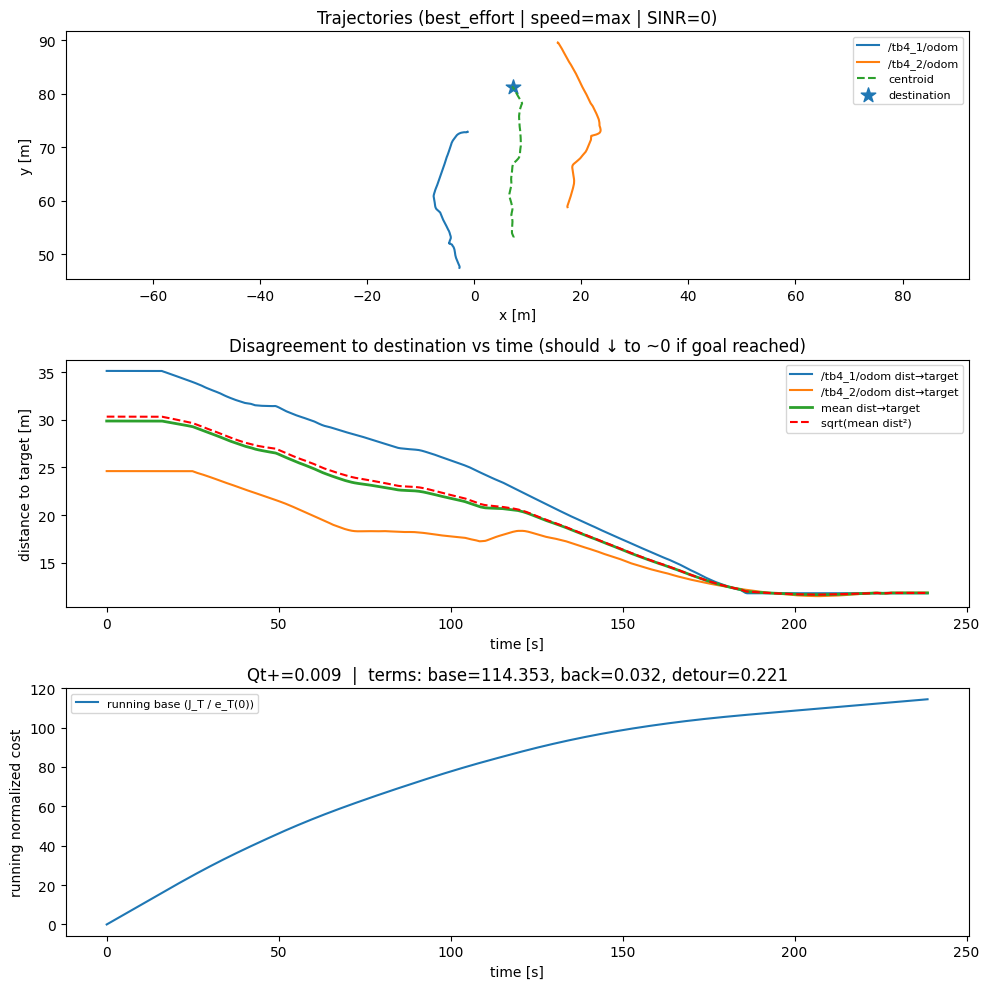


=== Processing: 2tb4_35SINR_besteffort_maxspeed_0.db3


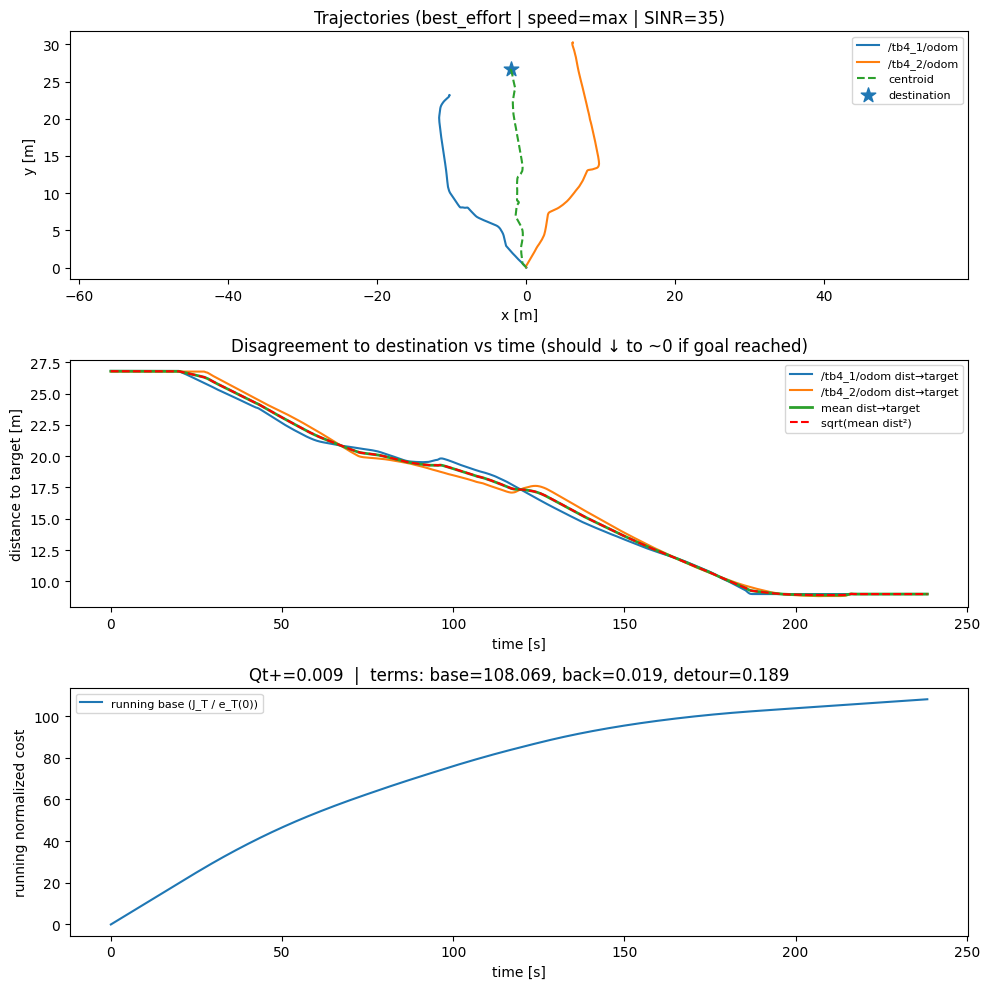


=== Processing: 2tb4_35SINR_besteffort_maxspeed_2_0.db3


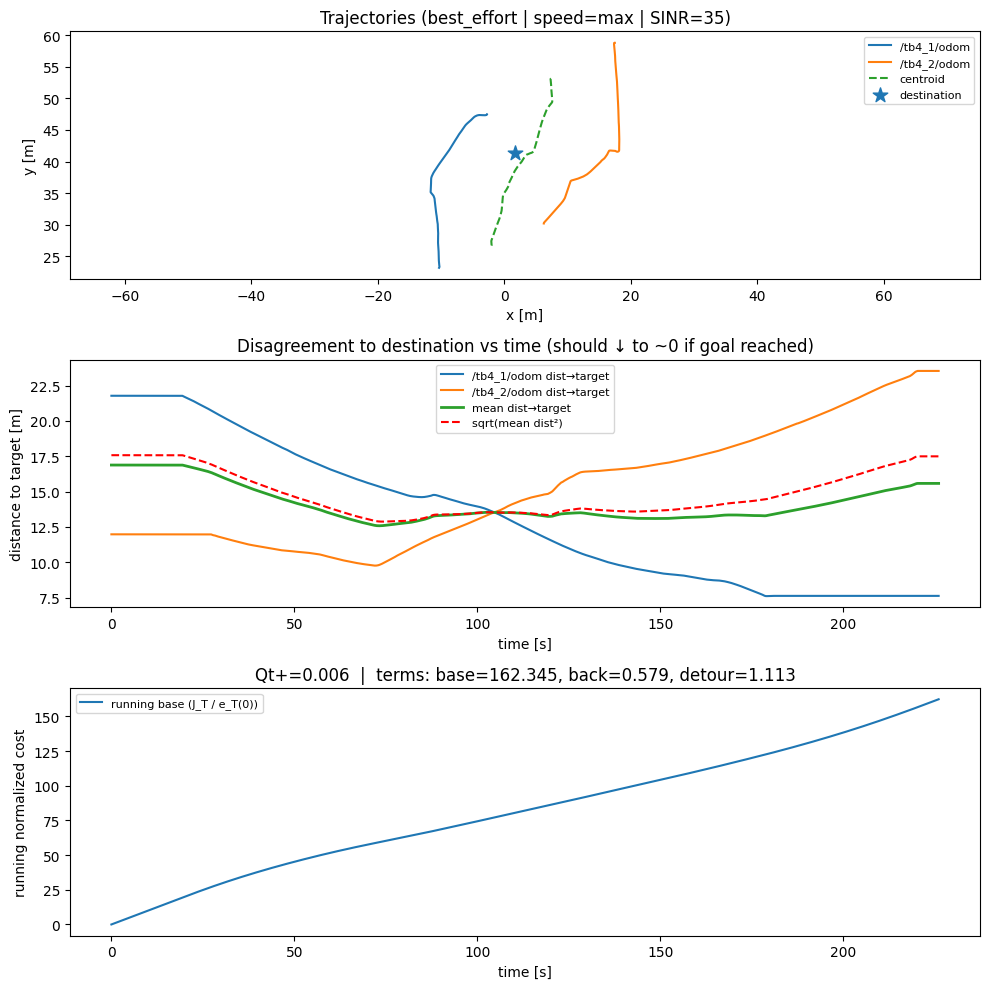


=== Processing: 2tb4_LIVE_SINR_besteffort_0.15speed_0.db3


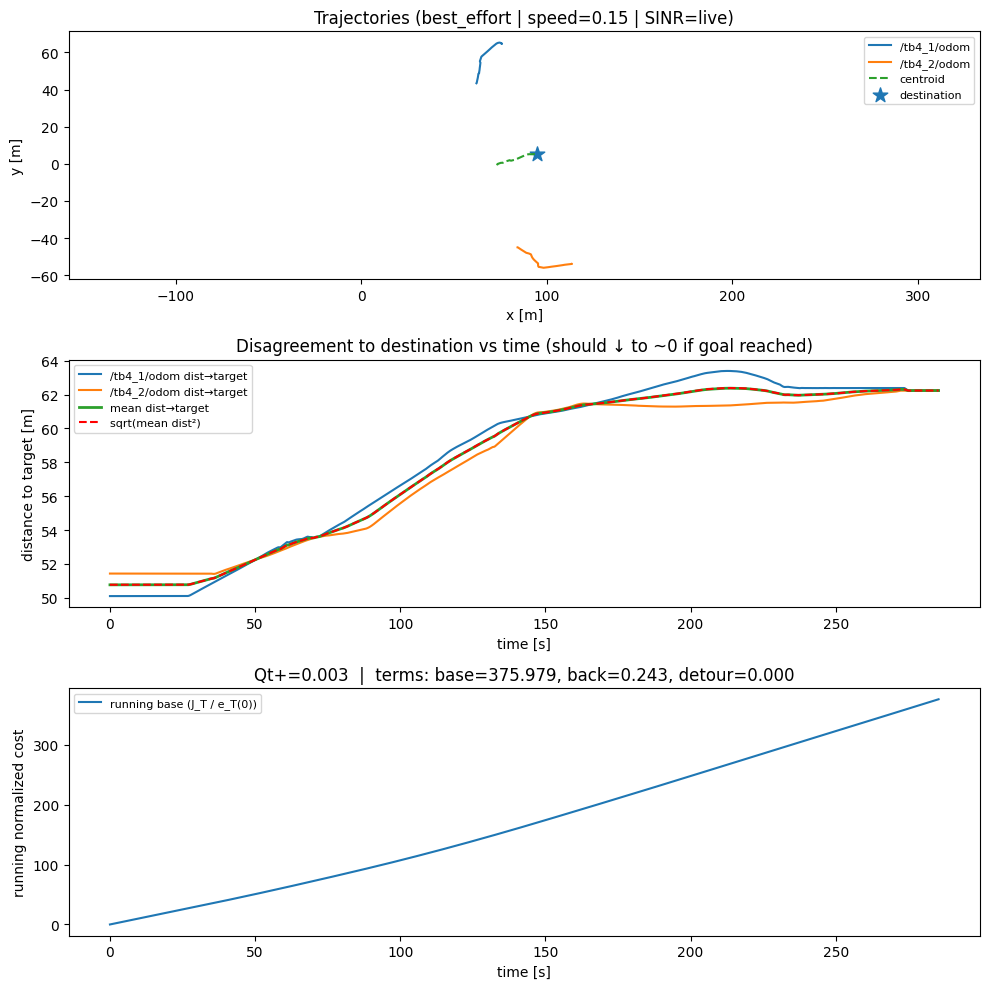


=== Processing: 2tb4_LIVE_SINR_besteffort_0.3speed_0.db3


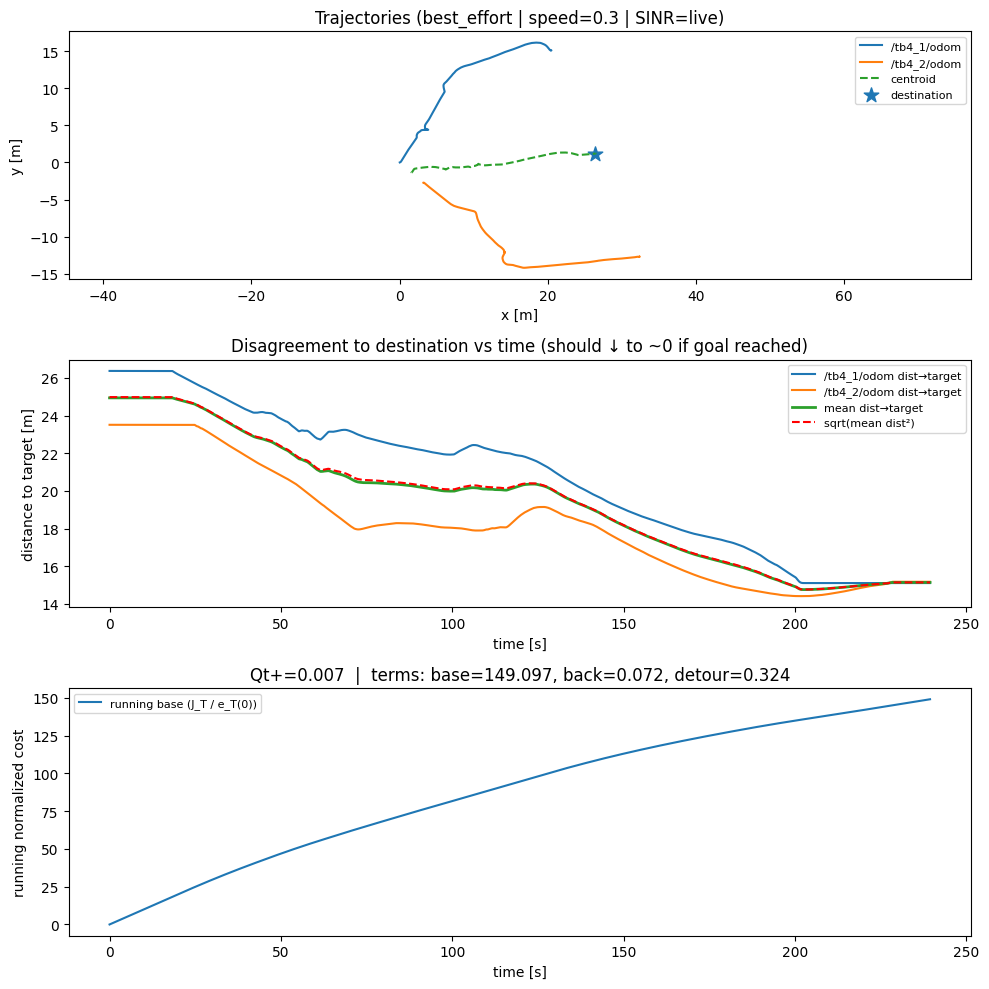


=== Processing: 2tb4_LIVE_SINR_besteffort_0.3speed_2_0.db3


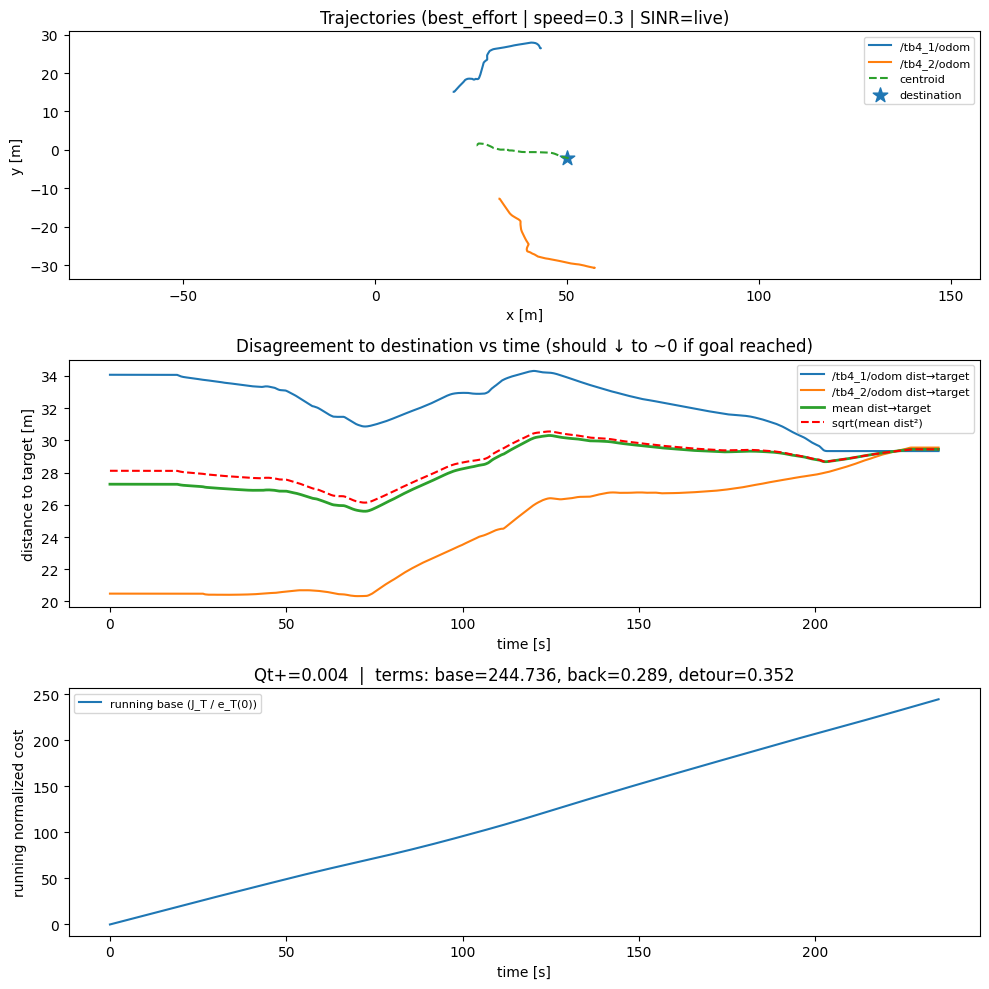


=== Processing: 2tb4_LIVE_SINR_besteffort_0.3speed_3_0.db3


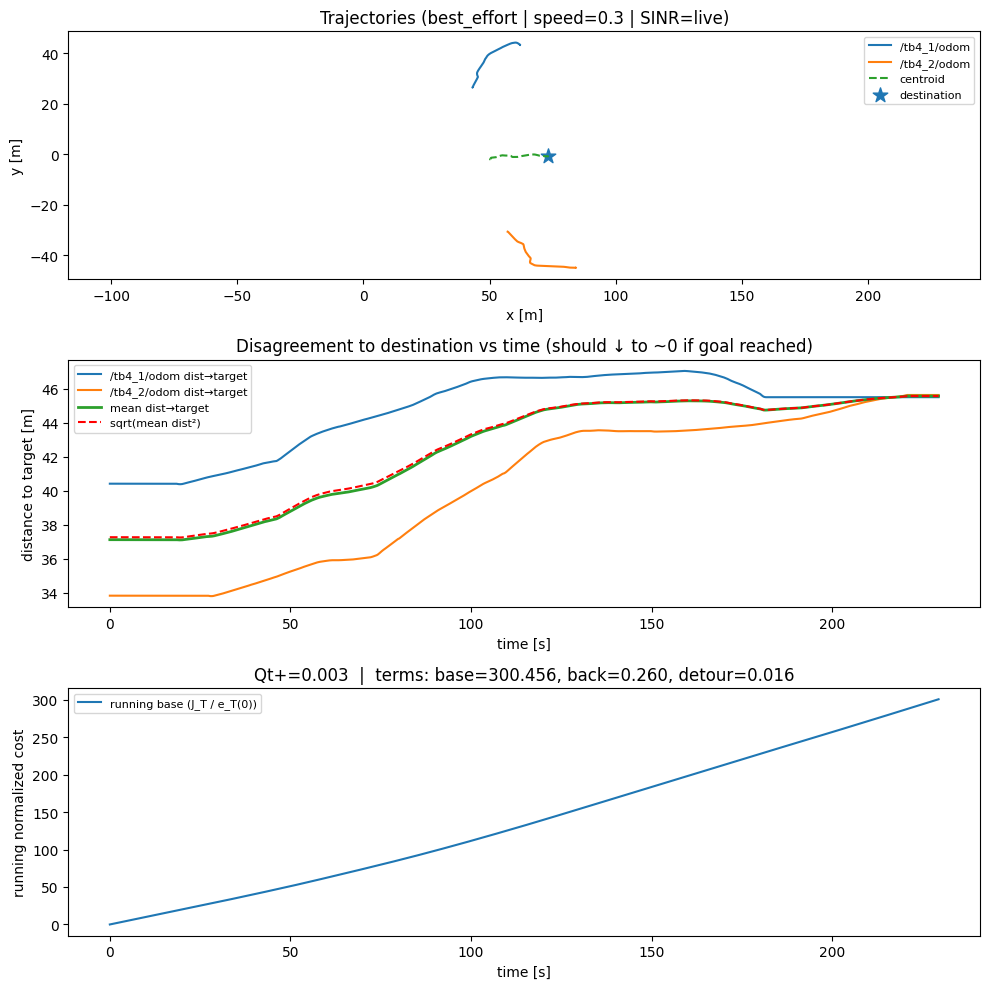


=== Processing: 2tb4_LIVE_SINR_besteffort_maxspeed_0.db3


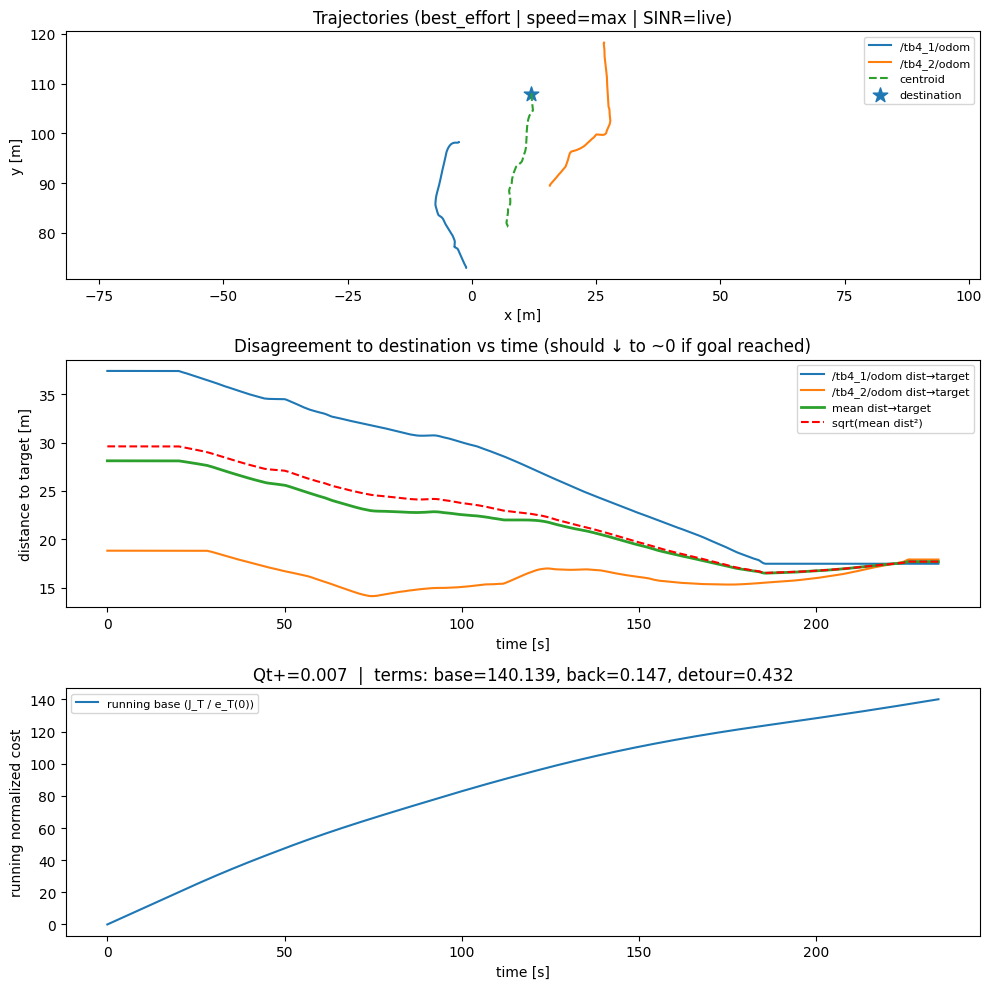


=== Processing: 2tb4_0SINR_besteffort_maxspeed_0.db3


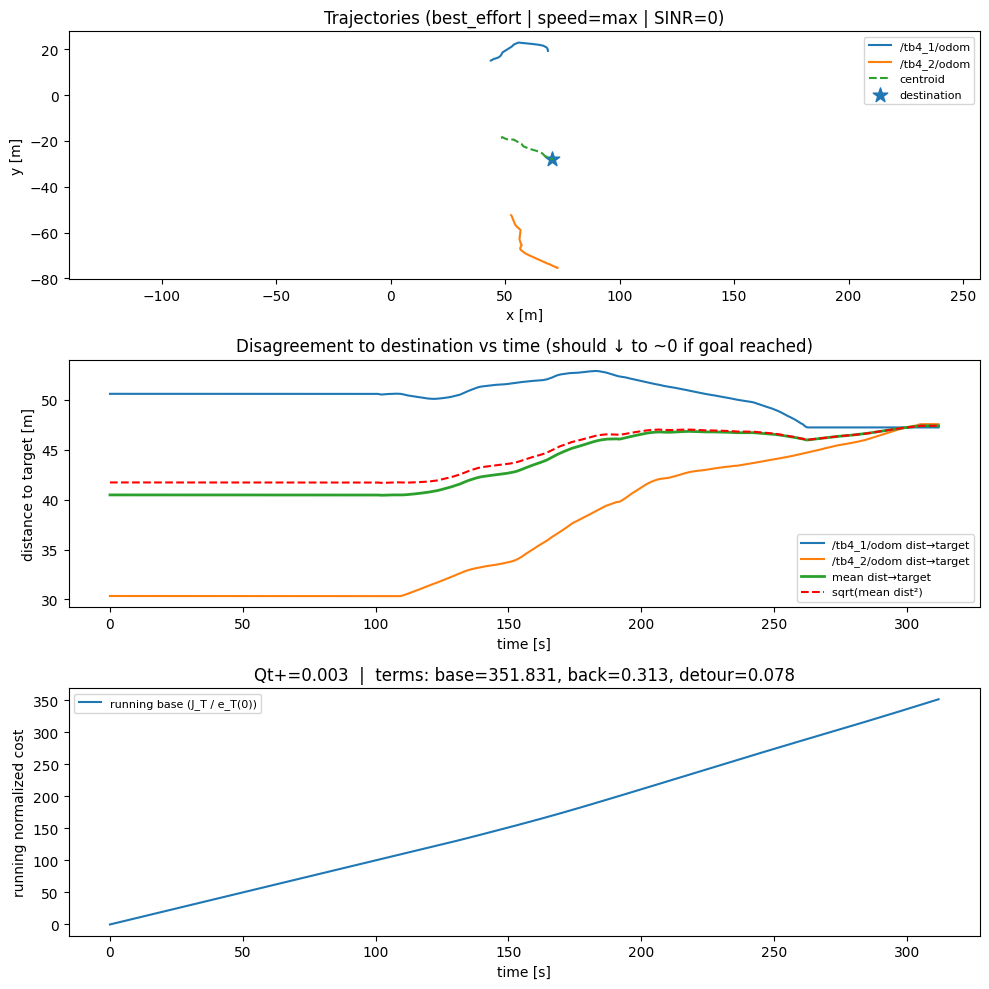


=== Processing: rosbag2_2025_10_27-20_37_41_0.db3


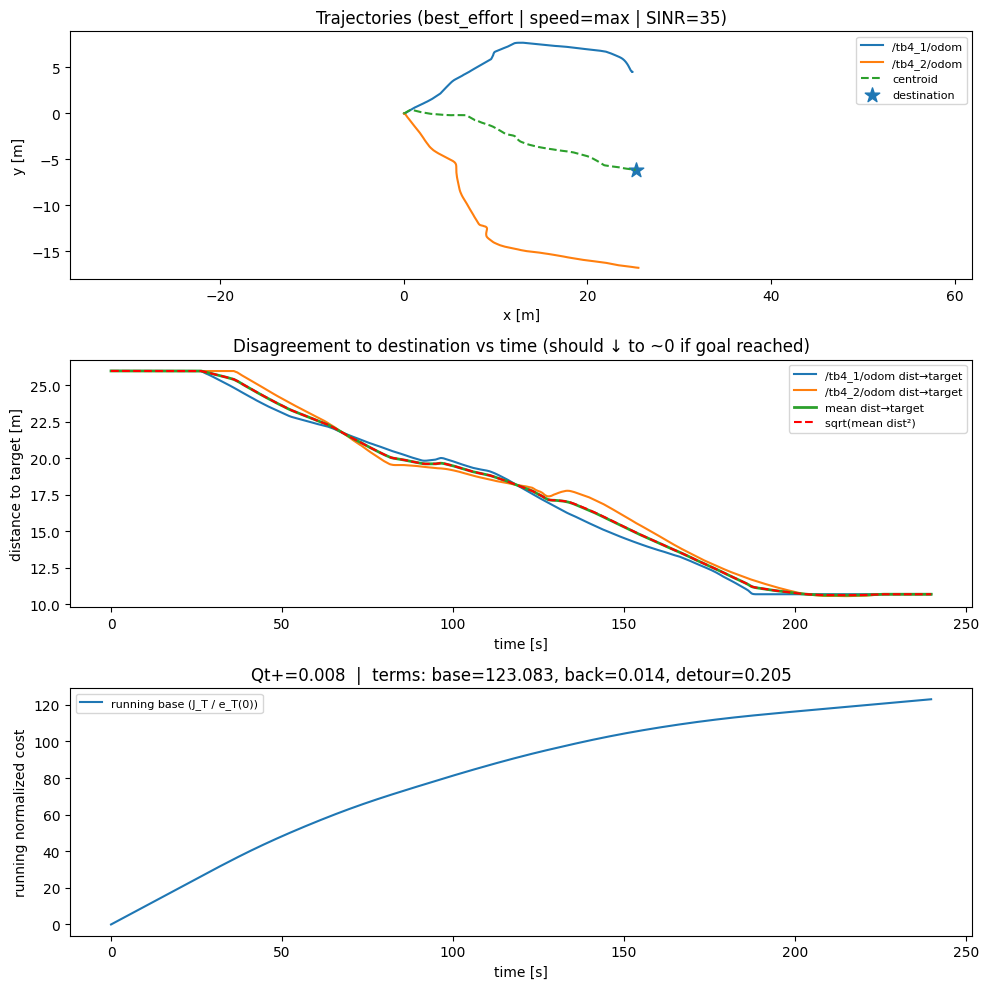


=== Processing: 2tb4_35SINR_besteffort_maxspeed_2_0.db3


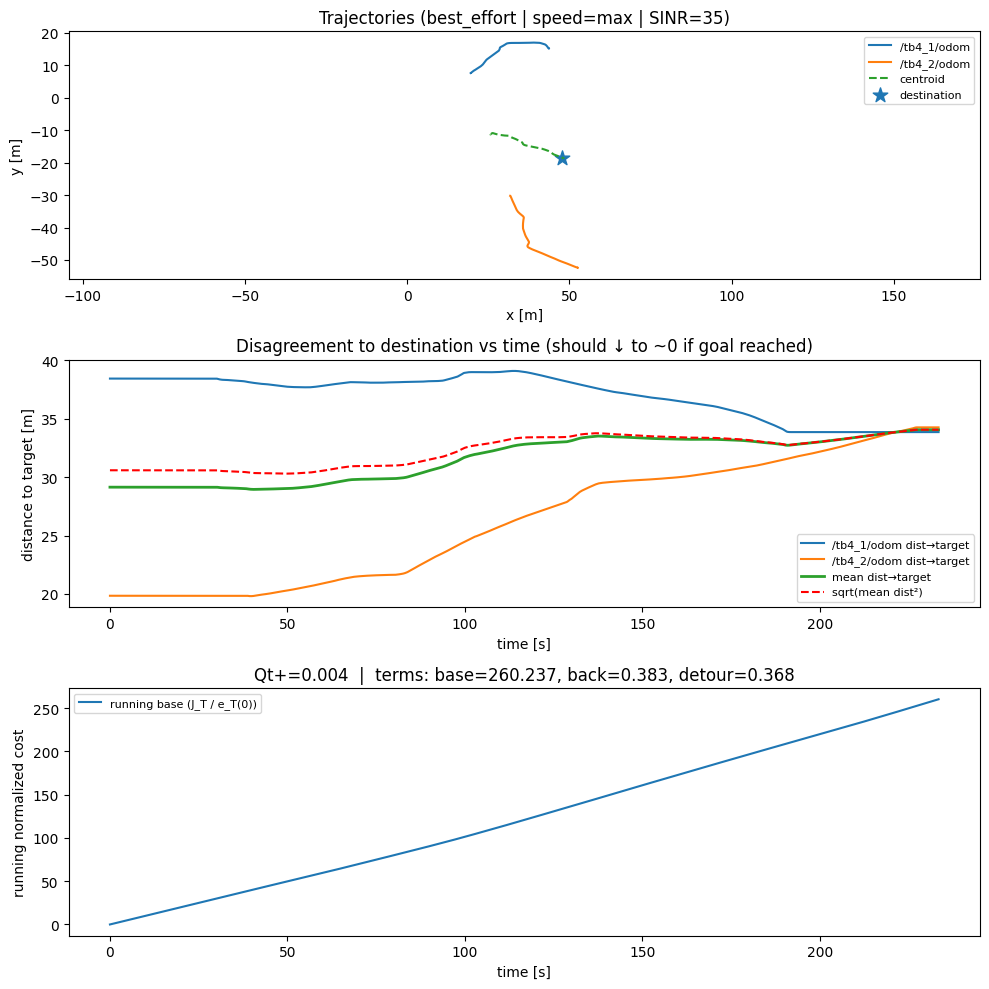


=== Processing: 2tb4_LIVE_SINR_besteffort_maxspeed_0.db3


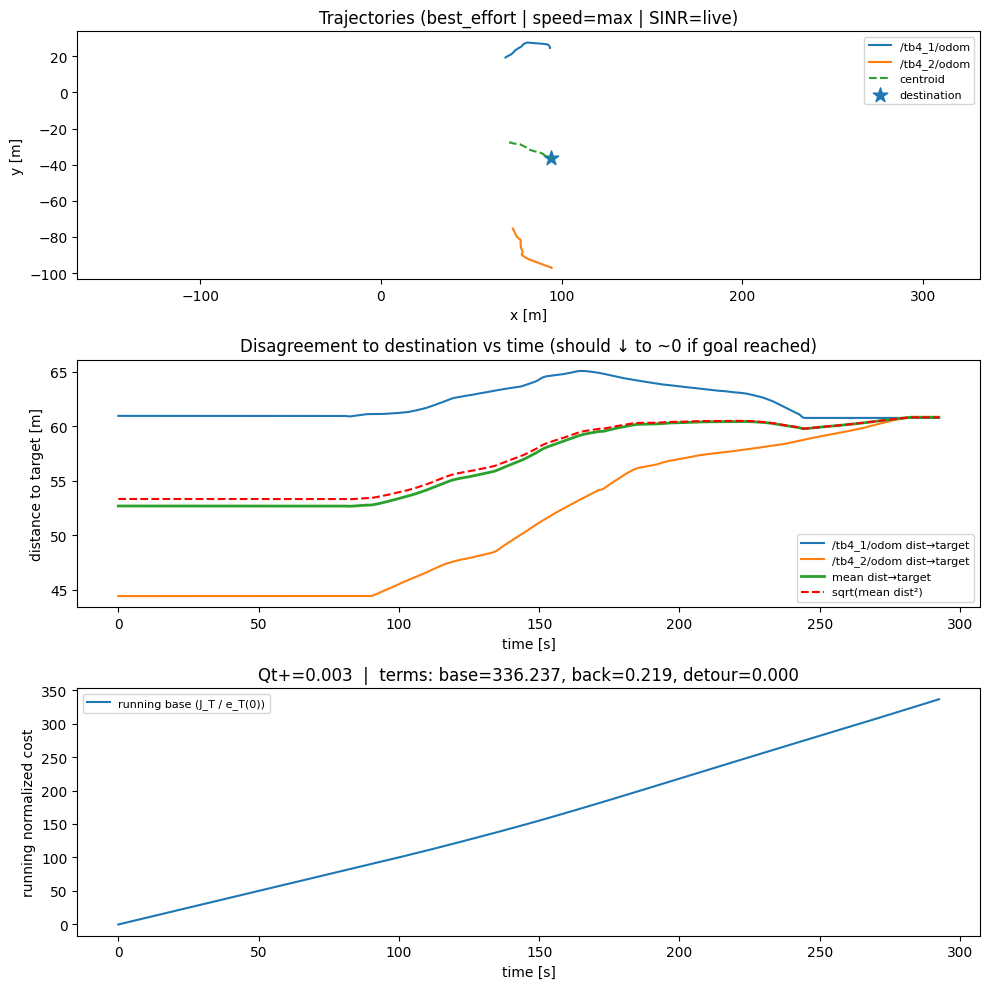


=== Processing: rosbag2_2025_10_27-21_04_45_0.db3


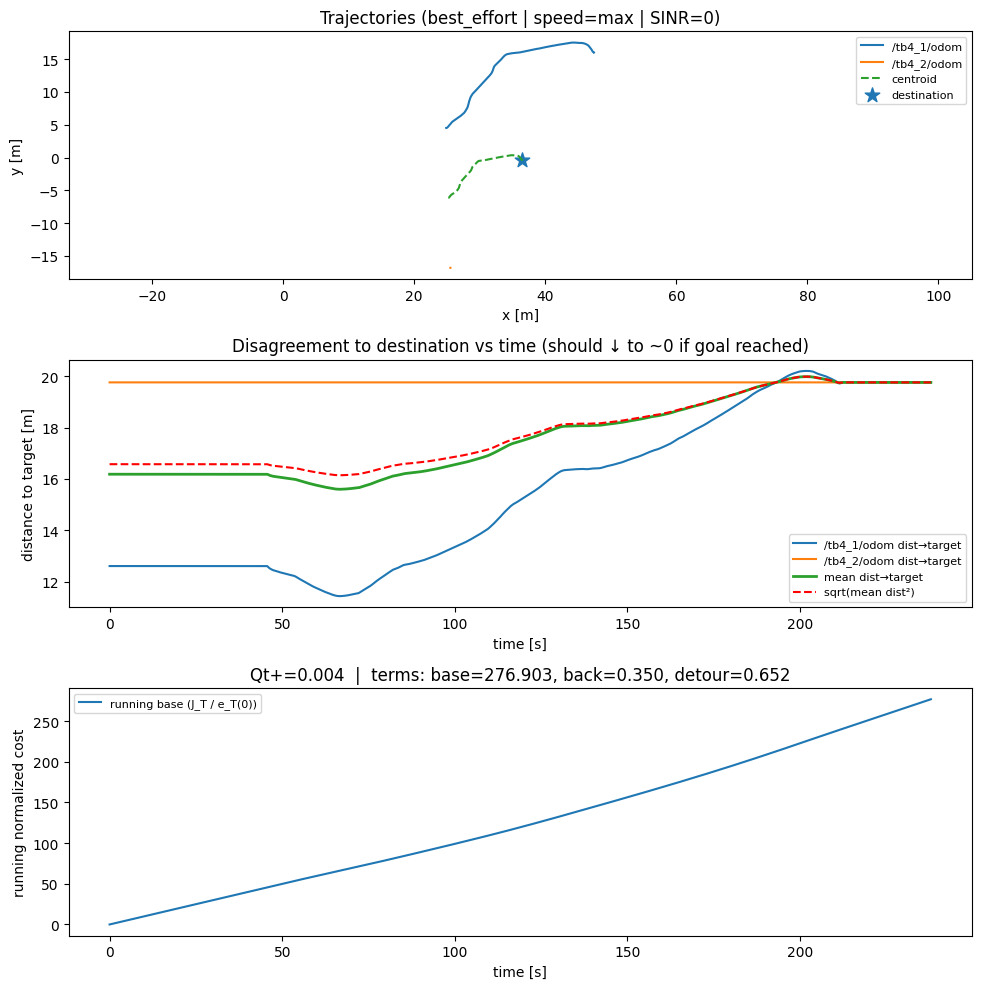


=== Processing: 2tb4_0SINR_reliable_maxspeed_0.db3


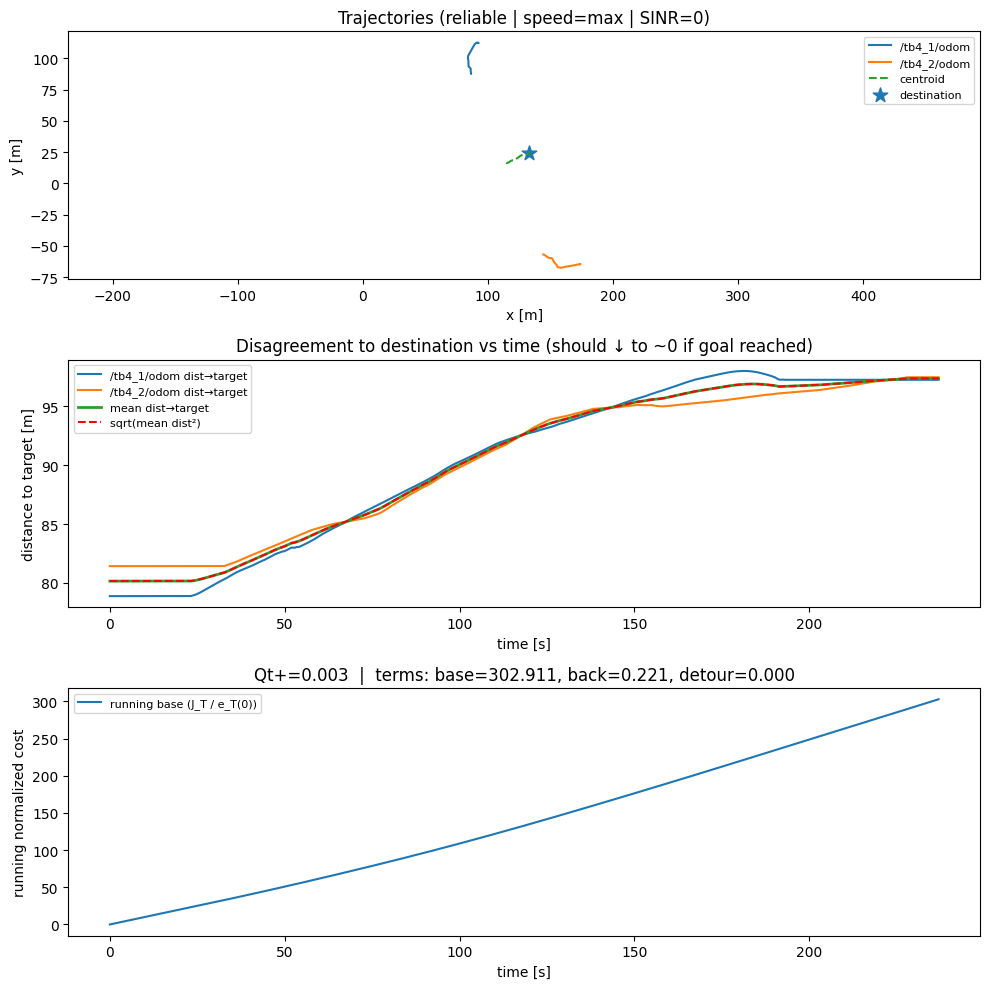


=== Processing: 2tb4_35SINR_reliable_maxspeed_0.db3


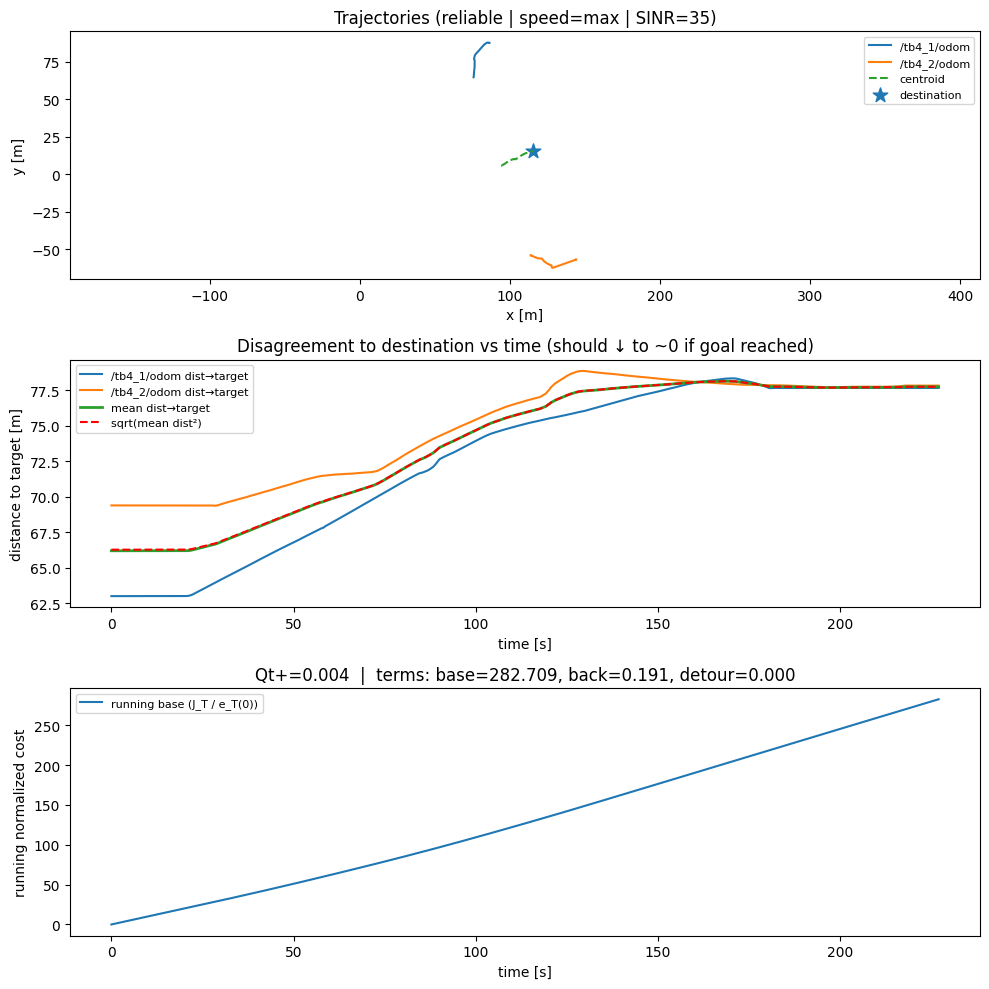


=== Processing: 2tb4_LIVE_SINR_reliable_0.15speed_0.db3


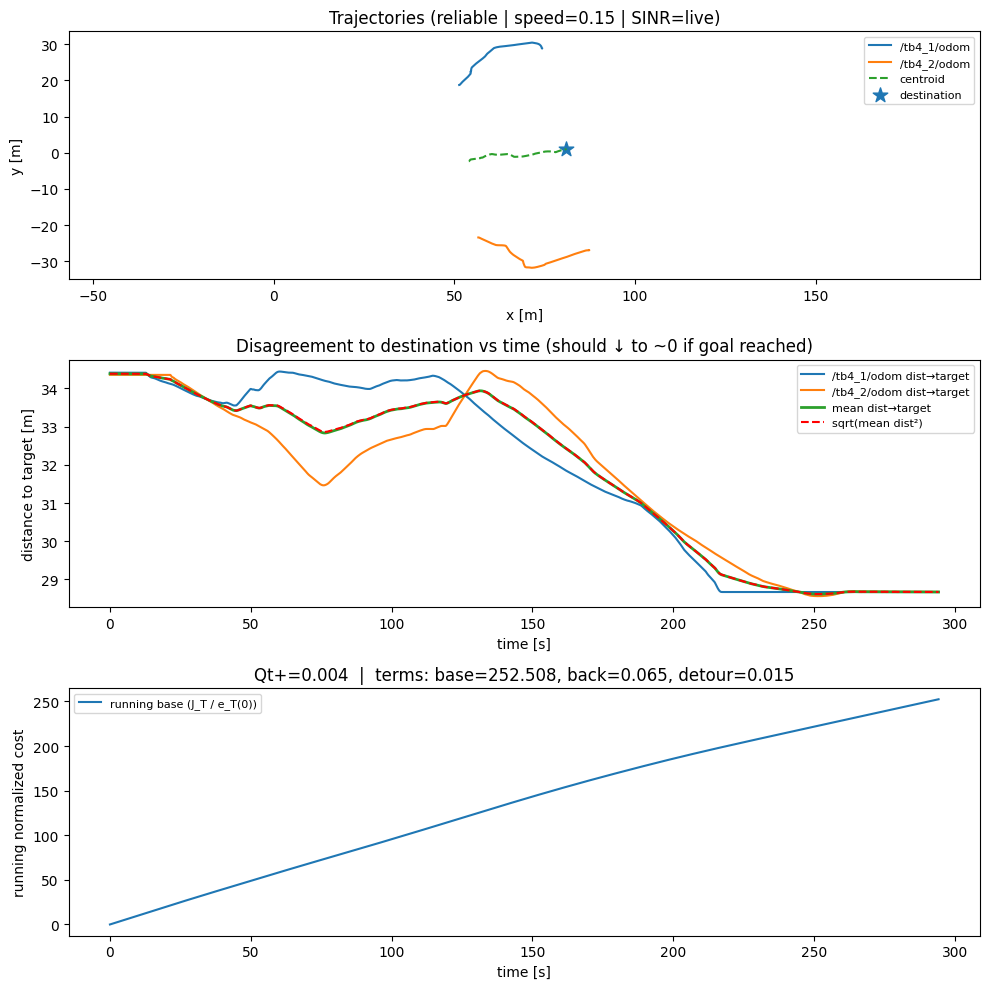


=== Processing: 2tb4_LIVE_SINR_reliable_0.3speed_0.db3


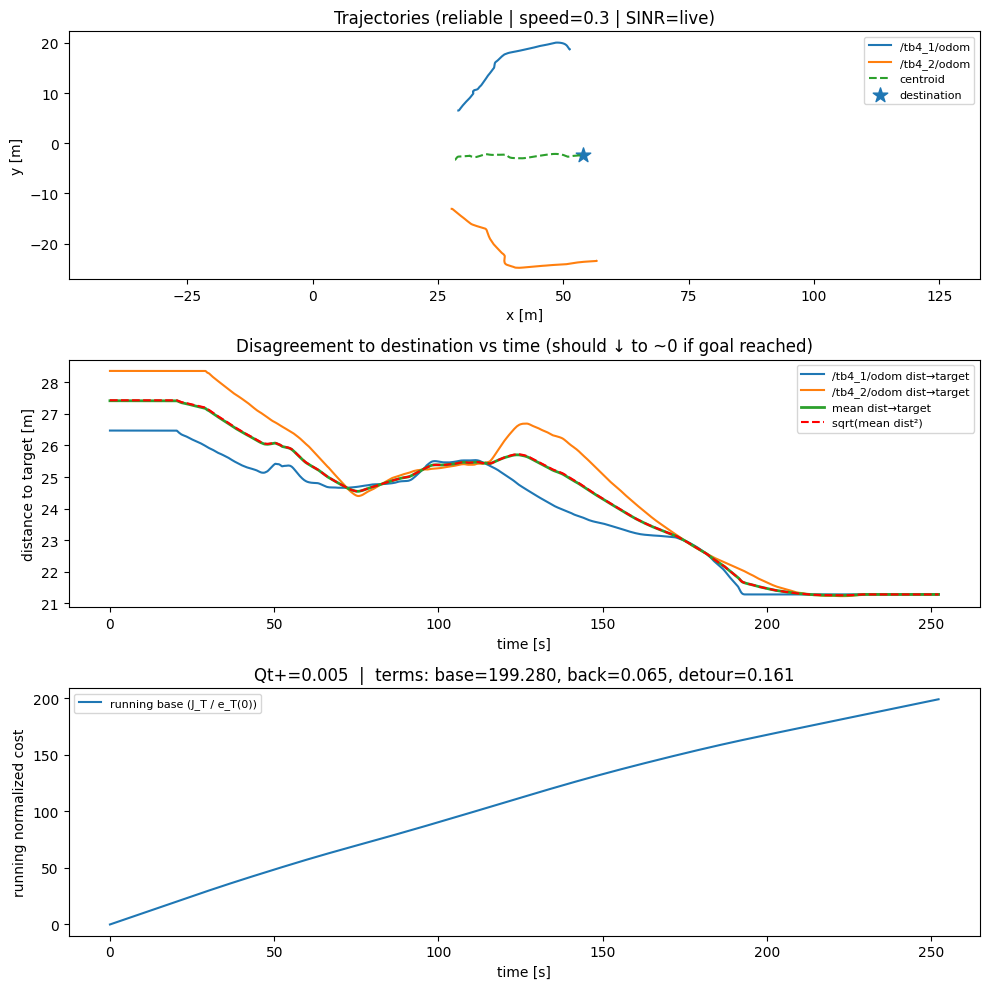


=== Processing: 2tb4_LIVE_SINR_reliable_maxspeed_0.db3


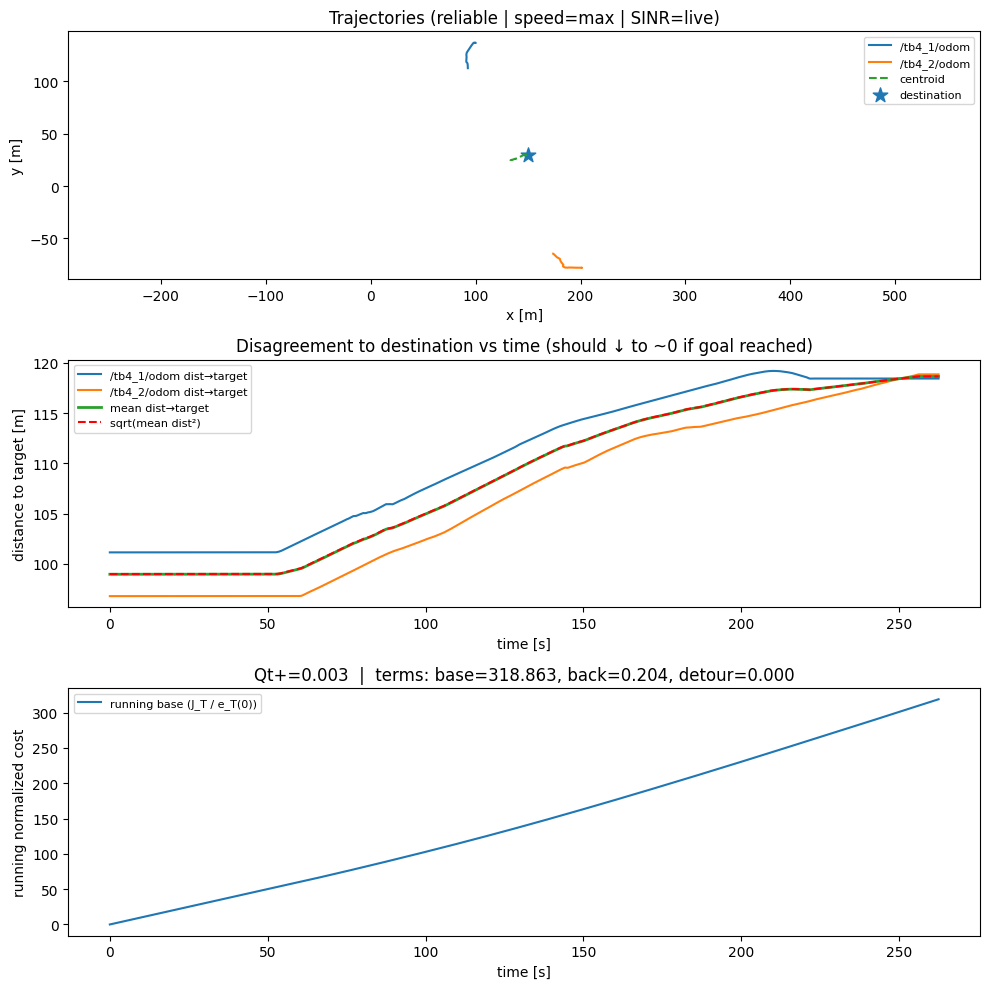


=== Processing: 2tb4_LIVE_SINR_reliable_maxspeed_2_0.db3


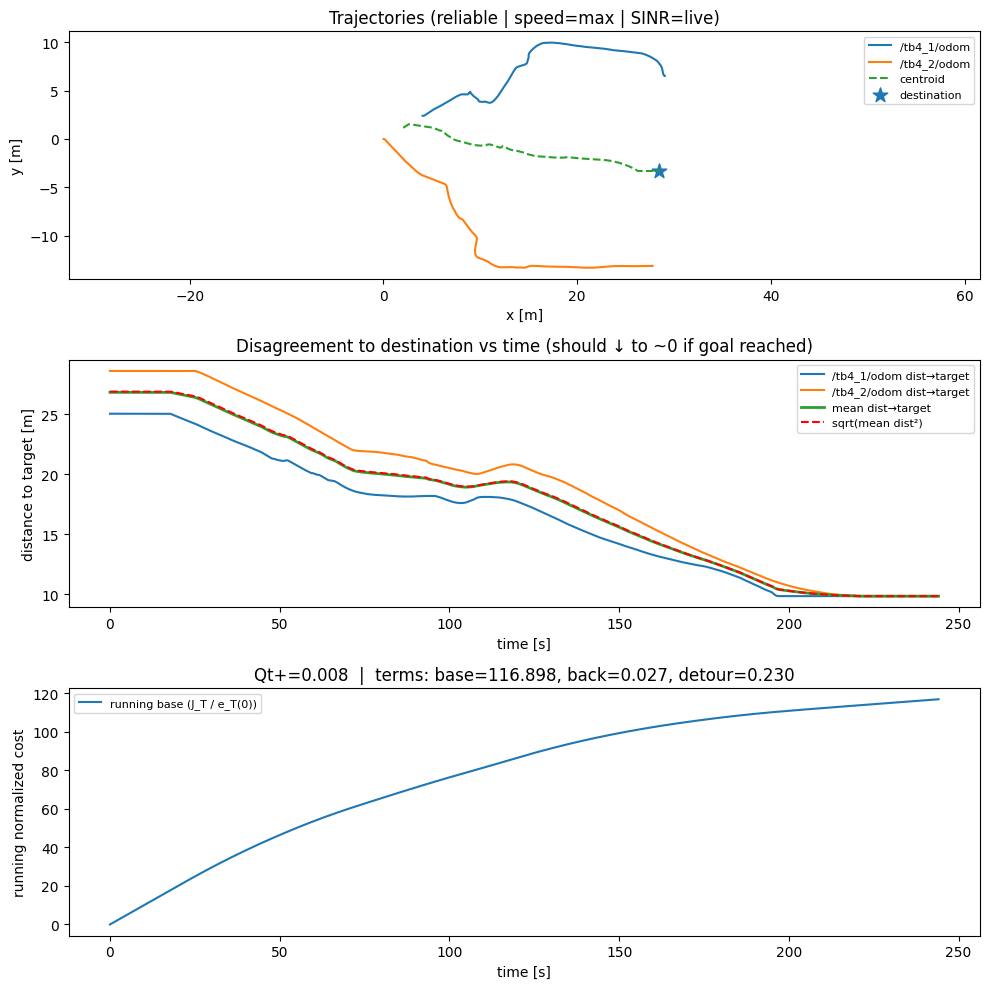


=== Processing: Hallway_35_SINR_reliable_maxspeed_0.db3
Skip Hallway_35_SINR_reliable_maxspeed_0.db3: need 2 odom topics, found ['/tb4_1/odom']

=== Processing: Hallway_LIVE_SINR_reliable_maxspeed_0.db3
Skip Hallway_LIVE_SINR_reliable_maxspeed_0.db3: need 2 odom topics, found ['/tb4_1/odom']

=== Processing: 2tb4_LIVE_SINR_reliable_maxspeed_2_0.db3


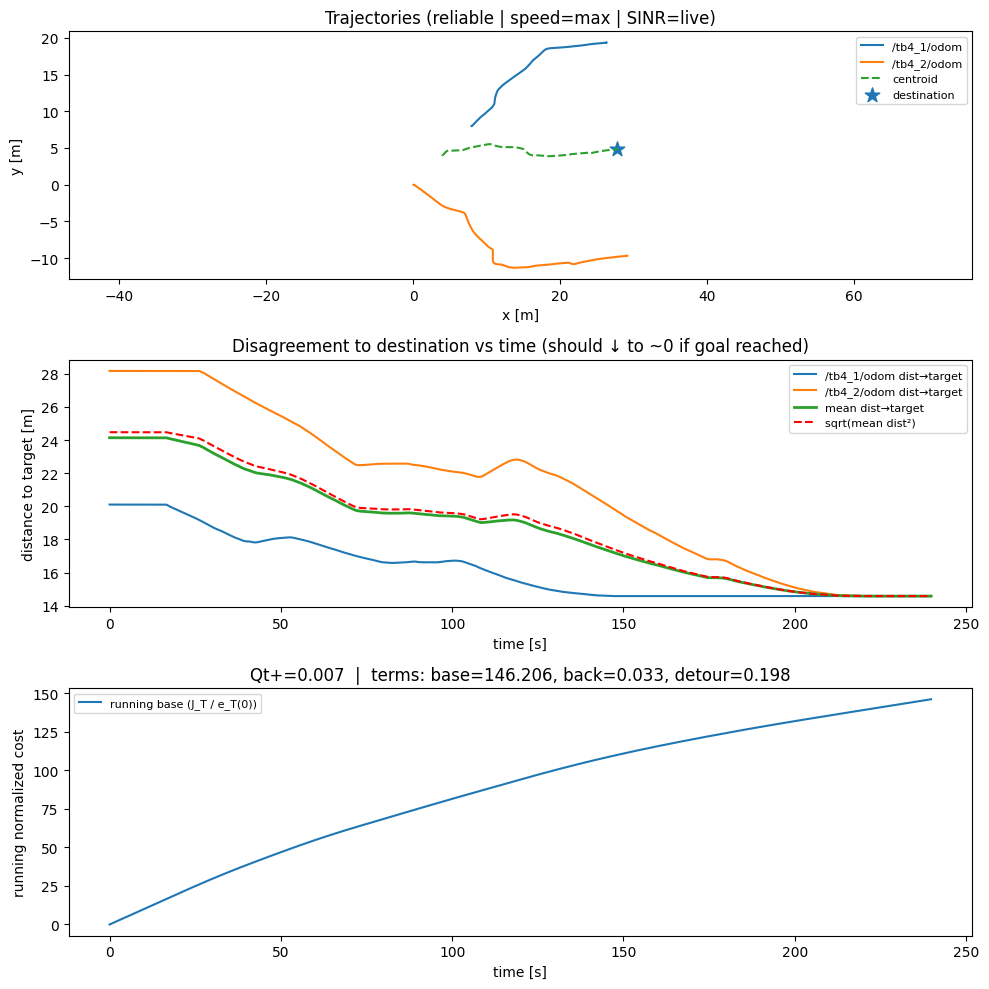


=== Processing: pair_2tb4_0SINR_besteffort_maxspeed_0.db3_vs_2tb4_0SINR_reliable_maxspeed_0.db3
Error: pair_2tb4_0SINR_besteffort_maxspeed_0.db3_vs_2tb4_0SINR_reliable_maxspeed_0.db3 -> Expected metadata file 'qoc_v4_out/pair_2tb4_0SINR_besteffort_maxspeed_0.db3_vs_2tb4_0SINR_reliable_maxspeed_0.db3' does not exist.

=== Processing: pair_2tb4_35SINR_besteffort_maxspeed_0.db3_vs_2tb4_35SINR_reliable_maxspeed_0.db3
Error: pair_2tb4_35SINR_besteffort_maxspeed_0.db3_vs_2tb4_35SINR_reliable_maxspeed_0.db3 -> Expected metadata file 'qoc_v4_out/pair_2tb4_35SINR_besteffort_maxspeed_0.db3_vs_2tb4_35SINR_reliable_maxspeed_0.db3' does not exist.

=== Processing: pair_2tb4_35SINR_besteffort_maxspeed_2_0.db3_vs_2tb4_35SINR_reliable_maxspeed_0.db3
Error: pair_2tb4_35SINR_besteffort_maxspeed_2_0.db3_vs_2tb4_35SINR_reliable_maxspeed_0.db3 -> Expected metadata file 'qoc_v4_out/pair_2tb4_35SINR_besteffort_maxspeed_2_0.db3_vs_2tb4_35SINR_reliable_maxspeed_0.db3' does not exist.

=== Processing: pair_2tb

,bag,qos,sinr,speed,label,Qtplus,Qt_base,Eavg,Lavg,Davg
0,Best Effort/2tb4_LIVE_SINR_besteffort_0.15spee...,best_effort,NaN,0.15,2tb4_LIVE_SINR_besteffort_0.15speed_0.db3,0.002652,375.978720,33.999229,32.403305,27.972488
1,Best Effort/2tb4_LIVE_SINR_besteffort_0.3speed...,best_effort,NaN,0.3,2tb4_LIVE_SINR_besteffort_0.3speed_0.db3,0.006658,149.096766,34.348426,32.760384,28.166650
2,Best Effort/2tb4_LIVE_SINR_besteffort_0.3speed...,best_effort,NaN,0.3,2tb4_LIVE_SINR_besteffort_0.3speed_2_0.db3,0.004065,244.736012,34.336583,32.630829,28.017608
3,Best Effort/2tb4_LIVE_SINR_besteffort_0.3speed...,best_effort,NaN,0.3,2tb4_LIVE_SINR_besteffort_0.3speed_3_0.db3,0.003315,300.456385,33.135775,31.935562,28.045356
4,Best Effort/2tb4_0SINR_besteffort_maxspeed/2tb...,best_effort,0.0,max,2tb4_0SINR_besteffort_maxspeed_0.db3,0.008664,114.352969,33.765330,32.464245,28.115979
5,Old/2tb4_0SINR_besteffort_maxspeed/2tb4_0SINR_...,best_effort,0.0,max,2tb4_0SINR_besteffort_maxspeed_0.db3,0.002833,351.830517,33.624171,32.087987,28.046951
6,Old/Failed_2tb4_0SINR_besteffort_maxspeed/rosb...,best_effort,0.0,max,rosbag2_2025_10_27-21_04_45_0.db3,0.003594,276.903345,14.857602,14.523145,12.676232
7,Best Effort/2tb4_35SINR_besteffort_maxspeed_1/...,best_effort,35.0,max,2tb4_35SINR_besteffort_maxspeed_0.db3,0.009164,108.068986,33.247264,31.846605,28.123263
8,Best Effort/2tb4_35SINR_besteffort_maxspeed_2/...,best_effort,35.0,max,2tb4_35SINR_besteffort_maxspeed_2_0.db3,0.006101,162.345050,32.951382,31.717301,28.091036
9,Old/2tb4_35SINR_besteffort_maxspeed/rosbag2_20...,best_effort,35.0,max,rosbag2_2025_10_27-20_37_41_0.db3,0.008056,123.082994,32.621345,31.287196,27.954952


,speed,sinr,Qt_BE,Qt_REL,Qe_BE,Qe_REL,n
0,0.15,NaN,0.002652,0.003944,0.070205,0.238405,1
1,0.3,NaN,0.004679,0.004991,0.081753,0.239551,1
2,max,0.0,0.005030,0.003289,0.419888,0.106839,1
3,max,35.0,0.006786,0.003523,0.284265,0.231902,1
4,max,NaN,0.005020,0.006131,0.178786,0.312047,2


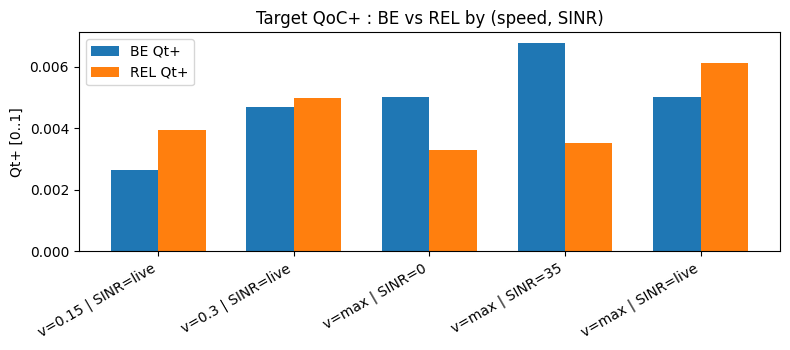

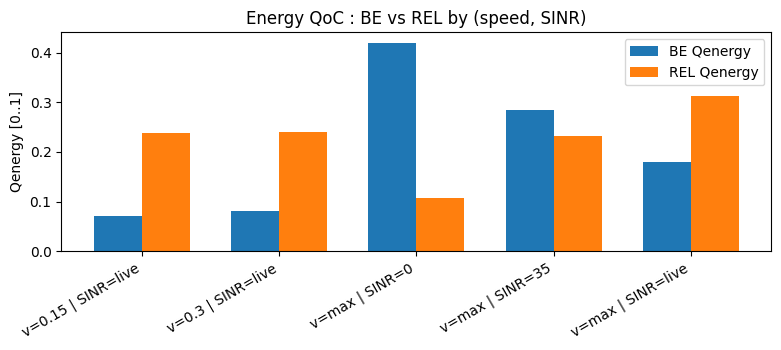

In [22]:
# %% End-to-end: load bags, compute refined Qtarg (Qt+), plot inline (no saves)

# --- Config -----------------------------------------------------------------
BAG_ROOT = ""      # change if needed
ROBOT_NS = ["tb4_1", "tb4_2"]
DT_RESAMPLE = 0.05          # seconds
V_STOP = 0.06               # m/s threshold to detect stopping windows
STOP_WINDOW_S = 6.0         # seconds of "slow" motion to define destination
FALLBACK_LAST_S = 10.0      # last seconds to average if no slow window
ALPHA_BACKTRACK = 0.6       # weight for backtracking penalty
GAMMA_DETOUR = 0.2          # weight for detour penalty in Qt+
ENERGY_SMOOTH_LMBDA = 0.2   # MPPI-ish smoothness penalty weight

# --- Imports & sanity --------------------------------------------------------
import os, re, glob, types, importlib
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

if not isinstance(pd, types.ModuleType) or not hasattr(pd, "DataFrame"):
    import pandas as _pandas
    pd = importlib.reload(_pandas)

# --- Rosbags helpers ---------------------------------------------------------
from rosbags.highlevel import AnyReader
from rosbags.typesys   import get_typestore, Stores

def make_typestore():
    for c in (Stores.ROS2_HUMBLE, Stores.ROS2_IRON, Stores.ROS2_JAZZY, Stores.ROS2_FOXY):
        try:
            return get_typestore(c)
        except Exception:
            pass
    return get_typestore(Stores.ROS2_HUMBLE)

def list_topics(reader):
    return sorted({c.topic for c in reader.connections})

def parse_meta_from_name(path):
    name   = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    text   = f"{parent}__{name}".replace(" ", "_")
    qos = "best_effort" if "besteffort" in text else ("reliable" if "reliable" in text else "unknown")
    sinr = None
    m = re.search(r"(\d+)\s*?sinr", text)
    if m: sinr = float(m.group(1))
    if "live_sinr" in text: sinr = np.nan
    speed = None
    m2 = re.search(r"(\d+(\.\d+)?)\s*speed", text)
    if m2: speed = float(m2.group(1))
    if "maxspeed" in text: speed = "max"
    return {"qos": qos, "sinr": sinr, "speed": speed, "label": os.path.basename(path)}

def extract_odom(reader, topic):
    conns = [c for c in reader.connections if c.topic == topic]
    rows  = []
    for conn in conns:
        for _conn, t_ns, raw in reader.messages(connections=[conn]):
            msg = reader.deserialize(raw, conn.msgtype)
            t   = t_ns * 1e-9
            try:
                hs = msg.header.stamp.sec + 1e-9*msg.header.stamp.nanosec
                if hs > 0 and abs(hs - t) < 1.0 and (not rows or hs >= rows[-1][0]):
                    t = hs
            except Exception:
                pass
            x  = getattr(msg.pose.pose.position,  "x", float("nan"))
            y  = getattr(msg.pose.pose.position,  "y", float("nan"))
            vx = getattr(msg.twist.twist.linear, "x", float("nan"))
            vy = getattr(msg.twist.twist.linear, "y", float("nan"))
            rows.append((t,x,y,vx,vy))
    if not rows: return None
    df = pd.DataFrame(rows, columns=["t","x","y","vx","vy"]).sort_values("t").drop_duplicates("t")
    return df

def resample_to_grid(trajs: dict, dt: float):
    tmin = min(df["t"].min() for df in trajs.values())
    tmax = max(df["t"].max() for df in trajs.values())
    T = np.arange(tmin, tmax + 0.5*dt, dt)

    def interp_or_hold(tt, arr):
        fin = np.isfinite(arr)
        if np.sum(fin) >= 2 and tt.size >= 2:
            return np.interp(T, tt, arr, left=arr[fin][0], right=arr[fin][-1])
        val = arr[fin][0] if np.any(fin) else 0.0
        return np.full_like(T, float(val))

    out = {}
    for name, df in trajs.items():
        tt = df["t"].to_numpy()
        out[name] = pd.DataFrame({
            "t": T,
            "x":  interp_or_hold(tt, df["x"].to_numpy()),
            "y":  interp_or_hold(tt, df["y"].to_numpy()),
            "vx": interp_or_hold(tt, df["vx"].to_numpy()),
            "vy": interp_or_hold(tt, df["vy"].to_numpy()),
        })
    return T, out

# --- Destination estimation (fixes the "never hits zero") --------------------
def estimate_common_destination_smart(traces, v_stop=V_STOP, stop_window_s=STOP_WINDOW_S, fallback_last_s=FALLBACK_LAST_S):
    """
    traces: dict {topic -> df[t,x,y,vx,vy]} on a *shared* time grid.
    1) Find the latest window where *each* robot's speed < v_stop for >= stop_window_s.
    2) Aggregate all (x,y) samples in the *union* of those slow windows (or fallback last_s).
    3) Return robust center (median) as (x*, y*).
    """
    T = next(iter(traces.values()))["t"].to_numpy()
    dt = np.diff(T, prepend=T[0])
    good_masks = []
    for df in traces.values():
        v = np.hypot(df["vx"].to_numpy(), df["vy"].to_numpy())
        slow = v < v_stop
        # Find latest slow segment of sufficient cumulated time
        runlen, idx_end = 0.0, None
        for k in range(len(T)-1, -1, -1):
            if slow[k]:
                runlen += dt[k]
                if runlen >= stop_window_s:
                    idx_end = k
                    break
            else:
                runlen = 0.0
        if idx_end is None:
            # fallback: last_s seconds
            mask = T >= T[-1] - fallback_last_s
        else:
            # take the slow segment just found
            t_start = T[idx_end] - stop_window_s
            mask = T >= t_start
        good_masks.append(mask)

    # union of (per-robot) chosen windows
    union_mask = np.zeros_like(T, dtype=bool)
    for m in good_masks:
        union_mask |= m

    xs, ys = [], []
    for df in traces.values():
        xs.append(df.loc[union_mask, "x"].to_numpy())
        ys.append(df.loc[union_mask, "y"].to_numpy())
    x_star = float(np.median(np.concatenate(xs))) if xs else 0.0
    y_star = float(np.median(np.concatenate(ys))) if ys else 0.0
    return x_star, y_star

# --- Energy-QoC --------------------------------------------------------------
def energy_qoc_runlevel(resampled, smooth_lambda=ENERGY_SMOOTH_LMBDA):
    names = list(resampled.keys())
    T  = resampled[names[0]]["t"].to_numpy()
    dt = np.diff(T, prepend=T[0])
    Ls, Es, Ds = [], [], []
    for name in names:
        x  = resampled[name]["x"].to_numpy(); y = resampled[name]["y"].to_numpy()
        vx = resampled[name]["vx"].to_numpy(); vy= resampled[name]["vy"].to_numpy()
        v  = np.hypot(vx, vy)
        L  = float(np.sum(np.hypot(np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0]))))
        a  = np.diff(v, prepend=v[0]) / np.where(dt>0, dt, 1.0)
        Es.append(L + smooth_lambda * float(np.sum((a*a) * dt)))
        Ls.append(L)
        Ds.append(float(np.hypot(x[-1]-x[0], y[-1]-y[0])))
    Eavg, Lavg, Davg = np.mean(Es), np.mean(Ls), np.mean(Ds)
    return {"Eavg":Eavg, "Lavg":Lavg, "Davg":Davg, "eff":(Davg / Lavg if Lavg>1e-9 else 1.0)}

# --- Refined target QoC (Qt+) -----------------------------------------------
def target_qoc_plus(resampled, x_star, y_star, alpha=ALPHA_BACKTRACK, gamma=GAMMA_DETOUR):
    """
    Base: J_T / e_T(0)   (original Qtarg integrand)
    + alpha * backtracking penalty (distance increases)
    + gamma * detour penalty (path length ratio - 1), both averaged over robots.
    Score: 1 / (1 + term)
    """
    names = list(resampled.keys())
    T = resampled[names[0]]["t"].to_numpy()
    dt = np.diff(T, prepend=T[0])

    d_all = []
    n2_all = []
    back_all = []
    detour_all = []

    for name in names:
        df = resampled[name]
        x, y = df["x"].to_numpy(), df["y"].to_numpy()
        d = np.hypot(x - x_star, y - y_star)          # distance to dest
        d_all.append(d)
        n2_all.append(d*d)

        # backtracking: positive increments in distance
        inc = np.maximum(0.0, np.diff(d, prepend=d[0]))
        d0  = max(d[0], 1e-9)
        back_all.append(float(np.sum(inc)) / d0)

        # detour: path length vs straight-line-to-goal at start
        L   = float(np.sum(np.hypot(np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0]))))
        det = max(0.0, L / d0 - 1.0)
        detour_all.append(det)

    d_all   = np.vstack(d_all)         # (N, |T|)
    n2_all  = np.vstack(n2_all)
    e_avg   = n2_all.mean(axis=0)      # mean squared distance
    J_base  = float(np.sum(e_avg * dt))
    e0      = float(np.mean(n2_all[:,0]))
    if not np.isfinite(e0) or e0 <= 1e-12:
        k = max(5, e_avg.size//10)
        e0 = float(np.nanmean(e_avg[:k])) if k>0 else 1.0
        if not np.isfinite(e0) or e0 <= 1e-12: e0 = 1.0

    back_pen = float(np.mean(back_all))
    det_pen  = float(np.mean(detour_all))

    term = (J_base / e0) + alpha*back_pen + gamma*det_pen
    Qplus = 1.0 / (1.0 + term)

    # running curve for the base part (for intuition)
    Jcum_norm = np.cumsum(e_avg * dt) / e0
    return {"T":T, "n2_avg":e_avg, "d_all":d_all, "Jcum_norm_base":Jcum_norm,
            "Qplus":Qplus, "term":term, "back_pen":back_pen, "det_pen":det_pen,
            "x_star":x_star, "y_star":y_star}

# --- Pipeline: read a bag, compute, plot inline ------------------------------
def process_bag_inline(db3_path):
    meta = parse_meta_from_name(db3_path)
    typestore = make_typestore()
    bag_input = Path(db3_path)
    bag_dir   = bag_input.parent if bag_input.is_file() else bag_input

    with AnyReader([bag_dir], default_typestore=typestore) as reader:
        available = list_topics(reader)
        odom_topics = [f"/{ns}/odom" for ns in ROBOT_NS if f"/{ns}/odom" in available]
        if len(odom_topics) < 2:
            print(f"Skip {os.path.basename(db3_path)}: need 2 odom topics, found {odom_topics}")
            return None

        trajs = {tp: extract_odom(reader, tp) for tp in odom_topics}
        if any(df is None or len(df)==0 for df in trajs.values()):
            print(f"Skip {os.path.basename(db3_path)}: empty odom topic.")
            return None

    # resample
    T, res = resample_to_grid(trajs, DT_RESAMPLE)

    # destination from stop region (shared time base) -> fixes "doesn't go to 0"
    x_star, y_star = estimate_common_destination_smart(res, V_STOP, STOP_WINDOW_S, FALLBACK_LAST_S)

    # compute metrics
    eq  = energy_qoc_runlevel(res)
    tqp = target_qoc_plus(res, x_star, y_star)

    # --- Inline plots (3 rows) ---------------------------------------------
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(3,1,1)
    for tp, df in res.items():
        ax1.plot(df["x"], df["y"], label=tp)
    # centroid path (context)
    X = np.vstack([res[tp]["x"].to_numpy() for tp in res])
    Y = np.vstack([res[tp]["y"].to_numpy() for tp in res])
    XC, YC = X.mean(axis=0), Y.mean(axis=0)
    ax1.plot(XC, YC, "--", label="centroid")
    ax1.scatter([x_star],[y_star], marker="*", s=120, label="destination")
    ax1.axis("equal"); ax1.set_xlabel("x [m]"); ax1.set_ylabel("y [m]")
    ax1.set_title(f"Trajectories ({meta['qos']} | speed={meta['speed']} | SINR={'live' if pd.isna(meta['sinr']) else int(meta['sinr'])})")
    ax1.legend(loc="best", fontsize=8)

    ax2 = plt.subplot(3,1,2)
    T0 = res[odom_topics[0]]["t"].to_numpy() - res[odom_topics[0]]["t"].iloc[0]
    colors = ["C0","C1"]
    for c,(tp,df) in zip(colors, res.items()):
        dist = np.hypot(df["x"]-x_star, df["y"]-y_star)
        ax2.plot(T0, dist, label=f"{tp} dist→target", color=c)
    d_mean = np.vstack([np.hypot(res[tp]["x"]-x_star, res[tp]["y"]-y_star) for tp in res]).mean(axis=0)
    ax2.plot(T0, d_mean, color="C2", label="mean dist→target", linewidth=2)
    ax2.plot(T0, np.sqrt(tqp["n2_avg"]), "r--", label="sqrt(mean dist²)")
    ax2.set_xlabel("time [s]"); ax2.set_ylabel("distance to target [m]")
    ax2.set_title("Disagreement to destination vs time (should ↓ to ~0 if goal reached)")
    ax2.legend(loc="best", fontsize=8)

    ax3 = plt.subplot(3,1,3)
    ax3.plot(T0, tqp["Jcum_norm_base"], label="running base (J_T / e_T(0))")
    ax3.set_xlabel("time [s]"); ax3.set_ylabel("running normalized cost")
    ax3.set_title(f"Qt+={tqp['Qplus']:.3f}  |  terms: base={tqp['Jcum_norm_base'][-1]:.3f}, "
                  f"back={tqp['back_pen']:.3f}, detour={tqp['det_pen']:.3f}")
    ax3.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

    return {
        "bag": db3_path, **meta,
        "Qtplus": float(tqp["Qplus"]),
        "Qt_base": float(tqp["Jcum_norm_base"][-1]),
        "Eavg": float(eq["Eavg"]),
        "Lavg": float(eq["Lavg"]),
        "Davg": float(eq["Davg"]),
    }

# --- Run all bags, collect metrics, show summaries --------------------------
def find_bags(root):
    return sorted(glob.glob(os.path.join(root, "**", "*.db3"), recursive=True))

bags = find_bags(BAG_ROOT)
if not bags:
    print("No .db3 bags found under:", BAG_ROOT)

results = []
for b in bags:
    try:
        print("\n=== Processing:", os.path.basename(b))
        r = process_bag_inline(b)
        if r: results.append(r)
    except Exception as e:
        print("Error:", os.path.basename(b), "->", e)

# --- Aggregate summaries and inline comparisons ------------------------------
if results:
    agg = pd.DataFrame(results)
    display(agg.sort_values(["qos","speed","sinr","bag"], na_position="last").reset_index(drop=True))

    # Robust normalization for Energy QoC to [0,1]
    q05, q95 = agg["Eavg"].quantile(0.05), agg["Eavg"].quantile(0.95)
    denom = max(1e-9, q95 - q05)
    agg["Qenergy"] = ((q95 - agg["Eavg"]) / denom).clip(0,1)

    # BE vs REL grouped bars for Qt+ and Qenergy by (speed,SINR)
    comp = (agg.groupby(["speed","sinr","qos"], dropna=False)[["Qtplus","Qenergy"]]
              .agg(["mean","count"]).reset_index())
    comp.columns = ["speed","sinr","qos","Qtplus_mean","Qtplus_n","Qenergy_mean","Qenergy_n"]
    pairs = []
    for (spd,snr), g in comp.groupby(["speed","sinr"], dropna=False):
        if set(g["qos"]) >= {"best_effort","reliable"}:
            be = g[g["qos"]=="best_effort"].iloc[0]
            rl = g[g["qos"]=="reliable"].iloc[0]
            pairs.append({
                "speed": spd, "sinr": snr,
                "Qt_BE": be["Qtplus_mean"], "Qt_REL": rl["Qtplus_mean"],
                "Qe_BE": be["Qenergy_mean"], "Qe_REL": rl["Qenergy_mean"],
                "n": int(min(be["Qtplus_n"], rl["Qtplus_n"]))
            })
    cmp = pd.DataFrame(pairs).sort_values(["speed","sinr"], na_position="last")
    if not cmp.empty:
        display(cmp)

        def lbl_speed(v): return "v=max" if v=="max" else (f"v={v}" if isinstance(v,float) else str(v))
        labels = [f"{lbl_speed(s)} | SINR={'live' if pd.isna(n) else int(n)}" for s,n in zip(cmp["speed"], cmp["sinr"])]
        x = np.arange(len(cmp)); w = 0.35

        plt.figure(figsize=(max(8, len(x)*0.9), 3.6))
        plt.bar(x-w/2, cmp["Qt_BE"],  width=w, label="BE Qt+")
        plt.bar(x+w/2, cmp["Qt_REL"], width=w, label="REL Qt+")
        plt.xticks(x, labels, rotation=30, ha="right"); plt.ylabel("Qt+ [0..1]")
        plt.title("Target QoC+ : BE vs REL by (speed, SINR)")
        plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(max(8, len(x)*0.9), 3.6))
        plt.bar(x-w/2, cmp["Qe_BE"],  width=w, label="BE Qenergy")
        plt.bar(x+w/2, cmp["Qe_REL"], width=w, label="REL Qenergy")
        plt.xticks(x, labels, rotation=30, ha="right"); plt.ylabel("Qenergy [0..1]")
        plt.title("Energy QoC : BE vs REL by (speed, SINR)")
        plt.legend(); plt.tight_layout(); plt.show()
    else:
        print("No matched (speed,SINR) groups with both QoS levels.")

else:
    print("No successful runs to summarize.")
